Netflix wants to identify similar movies based on movie characteristics.

https://www.kaggle.com/shivamb/netflix-shows

In [638]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import umap
import sklearn
from collections import Counter
from wordcloud import WordCloud
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Display preference
warnings.filterwarnings('ignore')
pd.set_option('Display.max_columns', 500)
pd.set_option('Display.max_rows', 10000)

In [639]:
netflix = pd.read_csv('../../data/netflix_titles.csv')

## Exploratory Data Analysis (EDA) 

In [640]:
# Initial info
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
show_id         6234 non-null int64
type            6234 non-null object
title           6234 non-null object
director        4265 non-null object
cast            5664 non-null object
country         5758 non-null object
date_added      6223 non-null object
release_year    6234 non-null int64
rating          6224 non-null object
duration        6234 non-null object
listed_in       6234 non-null object
description     6234 non-null object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [641]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


I decided to remove ```netflix['show_id']``` due to its irrelevance, ```netflix['director']``` due to the number of missing values present, ```netflix['release_year']``` since I will be using ```netflix['date_added]'``` and ```netflix['rating']```.

In [642]:
netflix = netflix.drop(['show_id', 'director', 'release_year', 'rating'], axis=1)
netflix = netflix.dropna(subset=['cast', 'date_added'])

For ```netflix['country']``` and ```netflix['rating']```, missing values were filled with the new value 'Unknown'.

In [643]:
netflix['country'] = netflix['country'].fillna('Unknown')

In ```netflix['description']```, commas were replaced with whitespace to prepare it for later use.

In [644]:
netflix['description'] = netflix['description'].str.replace(',', ' ')

I converted ```netflix['date_added']``` to an ```int``` datatype.

In [645]:
for date in zip(netflix['date_added'].index, netflix['date_added']):
    netflix['date_added'][date[0]] = date[1][-4:]
    
netflix['date_added'] = netflix['date_added'].astype('int64')

After making the above updates, the dimensions of the dataset:

In [646]:
print('Number of rows is {}'.format(netflix.shape[0]))
print('Number of columns is {}'.format(netflix.shape[1]))

Number of rows is 5654
Number of columns is 8


### Show Type

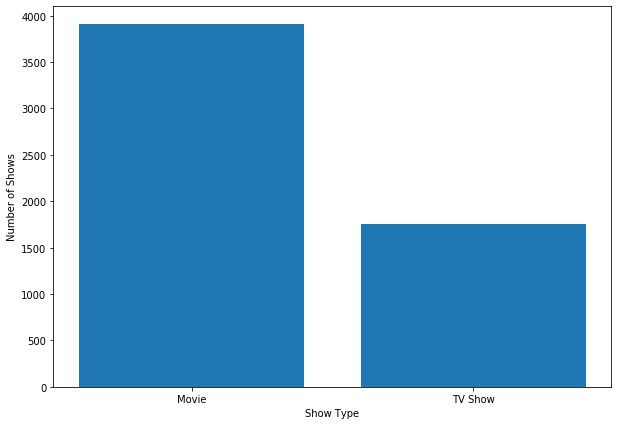

In [647]:
plt.figure(figsize=(10, 7))
plt.bar(netflix.groupby('type')['type'].count().index, netflix.groupby('type')['type'].count())
plt.ylabel('Number of Shows')
plt.xlabel('Show Type')
plt.show()

### Date Added

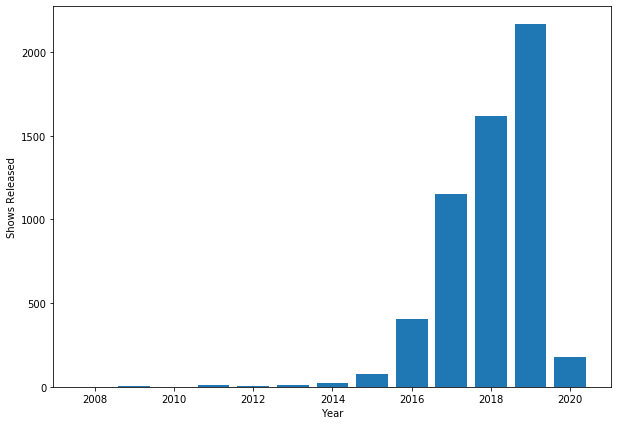

In [648]:
plt.figure(figsize=(10, 7))
plt.bar(netflix.groupby('date_added')['date_added'].count().index, 
        netflix.groupby('date_added')['date_added'].count())
plt.ylabel('Shows Released')
plt.xlabel('Year')
plt.show()

### Creation of Show Category Columns

In [649]:
# Create dataframe specific to show categories
netflix_show_categories = pd.DataFrame(netflix[['cast', 'listed_in', 'description']])

In [650]:
# Create a set for show categories
show_categories = set()

for show_category in netflix_show_categories['listed_in']:
    
    # Create list of show categories
    categories = show_category.split(',')
    
    # Add category to set
    for category in categories:
        show_categories.add(category.strip().lower())

In [651]:
# Create show category columns
for show_category in sorted(show_categories):
    
    # Assign initial value
    netflix_show_categories[show_category] = 0

In [652]:
# Retrieve index for description
index = netflix_show_categories.columns.tolist().index('description')

# Column list
netflix_show_columns = netflix_show_categories.columns[(index + 1):].tolist()

In [653]:
for show_category in zip(netflix_show_categories['listed_in'].index, netflix_show_categories['listed_in']):
    
    # Create list of show categories
    categories = show_category[1].split(',')
    
    for category in categories:
        
        # Remove whitespace and set to lowercase
        category = category.strip().lower()
        
        # If show category in show category columns
        if category in netflix_show_columns:
            
            # Update show category to True
            netflix_show_categories[category][show_category[0]] = 1

In [654]:
netflix_show_categories.head()

,cast,listed_in,description,action & adventure,anime features,anime series,british tv shows,children & family movies,classic & cult tv,classic movies,comedies,crime tv shows,cult movies,documentaries,docuseries,dramas,faith & spirituality,horror movies,independent movies,international movies,international tv shows,kids' tv,korean tv shows,lgbtq movies,movies,music & musicals,reality tv,romantic movies,romantic tv shows,sci-fi & fantasy,science & nature tv,spanish-language tv shows,sports movies,stand-up comedy,stand-up comedy & talk shows,teen tv shows,thrillers,tv action & adventure,tv comedies,tv dramas,tv horror,tv mysteries,tv sci-fi & fantasy,tv shows,tv thrillers
0,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...","Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Jandino Asporaat,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,"Peter Cullen, Sumalee Montano, Frank Welker, J...",Kids' TV,With the help of three human allies the Autob...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Will Friedle, Darren Criss, Constance Zimmer, ...",Kids' TV,When a prison ship crash unleashes hundreds of...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Nesta Cooper, Kate Walsh, John Michael Higgins...",Comedies,When nerdy high schooler Dani finally attracts...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


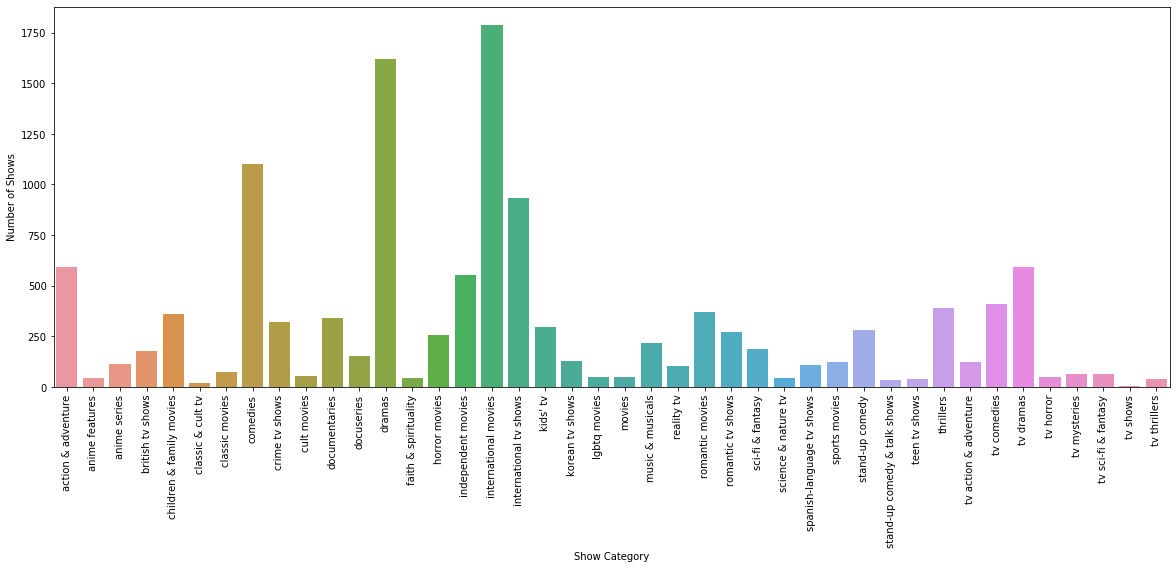

In [655]:
plt.figure(figsize=(20, 7))
sns.barplot(x=netflix_show_columns, y=netflix_show_categories[netflix_show_columns].sum())
plt.ylabel('Number of Shows')
plt.xlabel('Show Category')
plt.xticks(rotation=90)
plt.show()

### Creation of Country Columns

In [656]:
# Create dataframe specific to show countries
netflix_show_countries = pd.DataFrame(netflix['country'])

In [657]:
# Create set for show countries
countries = set()

for country in netflix_show_countries['country']:
  
    # Create list for show countries
    show_countries = country.split(',')

    # Remove empty string
    if '' in show_countries:
        show_countries.remove('')
    
    # Add show country to countries set
    for show_country in show_countries:
        countries.add(show_country.strip().lower())

In [658]:
# Create show country columns
for country in sorted(countries):
    
    # Assign initial value
    netflix_show_countries[country] = 0

In [659]:
# Retrieve index for country
index = netflix_show_countries.columns.tolist().index('country')

# Column list
netflix_country_columns = netflix_show_countries.columns[(index + 1):].tolist()

In [660]:
for country in zip(netflix_show_countries['country'].index, netflix_show_countries['country']):
    
    # Create list of show countries
    show_countries = country[1].split(',')
    
    for show_country in show_countries:
        
        # Remove whitespace and set to lowercase
        show_country = show_country.strip().lower()
        
        # If show country in show country columns
        if show_country in netflix_country_columns:
            
            # Update show country to True
            netflix_show_countries[show_country][country[0]] = 1

In [661]:
netflix_show_countries.head()

,country,afghanistan,albania,argentina,australia,austria,azerbaijan,bangladesh,belgium,bermuda,brazil,bulgaria,cambodia,canada,cayman islands,chile,china,colombia,croatia,cuba,cyprus,czech republic,denmark,dominican republic,east germany,ecuador,egypt,finland,france,georgia,germany,ghana,greece,guatemala,hong kong,hungary,iceland,india,indonesia,iran,iraq,ireland,israel,italy,japan,jordan,kenya,kuwait,latvia,lebanon,liechtenstein,luxembourg,malawi,malaysia,malta,mauritius,mexico,montenegro,morocco,nepal,netherlands,new zealand,nicaragua,nigeria,norway,pakistan,panama,paraguay,peru,philippines,poland,portugal,qatar,romania,russia,saudi arabia,senegal,serbia,singapore,slovakia,slovenia,somalia,south africa,south korea,soviet union,spain,sri lanka,sudan,sweden,switzerland,syria,taiwan,thailand,turkey,ukraine,united arab emirates,united kingdom,united states,unknown,uruguay,vatican city,venezuela,vietnam,west germany
0,"United States, India, South Korea, China",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,United Kingdom,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,United States,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


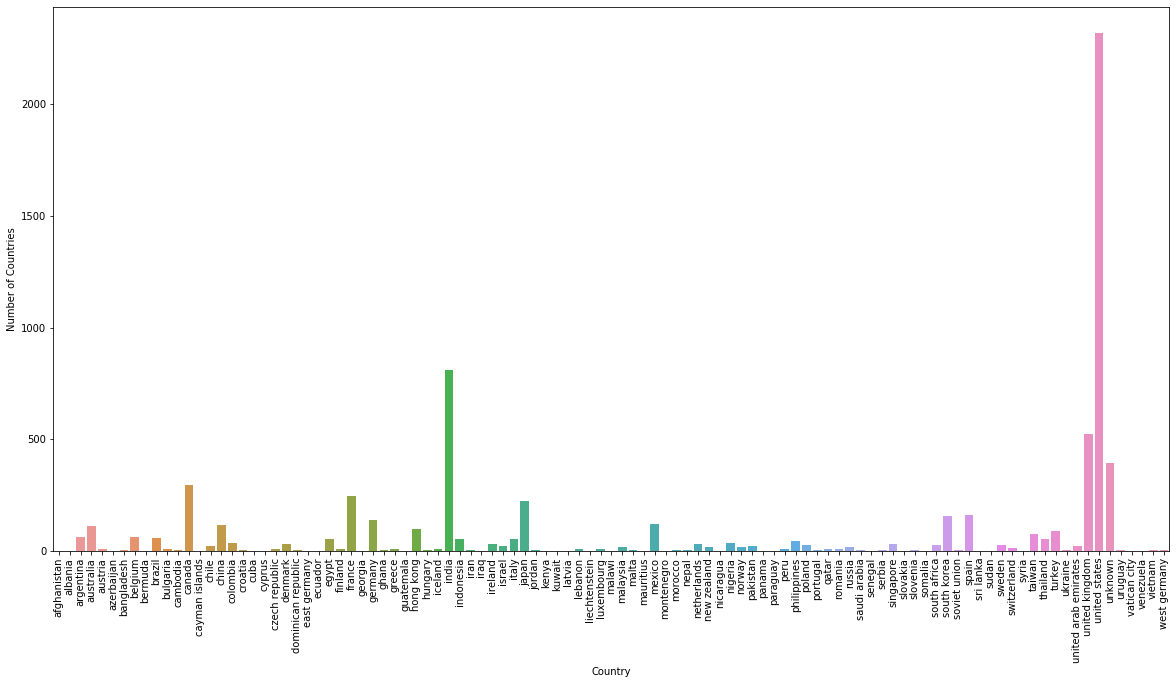

In [662]:
plt.figure(figsize=(20, 10))
sns.barplot(x=netflix_country_columns, y=netflix_show_countries[netflix_country_columns].sum())
plt.ylabel('Number of Countries')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.show()

### Creation of Keyword Columns

In [663]:
# Create dataframe specific to show keyword(s)
netflix_show_description = pd.DataFrame(netflix['description'])

In [664]:
for column in netflix_show_columns:
    
    # Empty string
    column_words = ''
    
    # String to capture all words associated with the show category
    for desc in netflix_show_categories[netflix_show_categories[column] == 1]['description']:
        column_words += desc
        
    # Create WordCloud object
    wc = WordCloud().generate(column_words)
    
    # Create list of most frequent words for the show category
    column_keywords = [keyword for keyword in wc.words_.keys()]
    
    # Create show description columns for the top 10 words
    for column_keyword in column_keywords[:10]:
        column_keyword = column_keyword.strip().lower()
        netflix_show_description[column_keyword] = 0

In [665]:
# Retrieve index for description
index = netflix_show_description.columns.tolist().index('description')

# Column list
netflix_keyword_columns = netflix_show_description.columns[(index + 1):].tolist()

In [666]:
for description in zip(netflix_show_categories['description'].index, netflix_show_categories['description']):
    
    # Create list of show description
    show_description = description[1].split(' ')
    
    for desc in show_description:
        
        # Remove whitespace and set to lowercase
        desc = desc.strip().lower()
        
        # If show description words in keyword columns
        if desc in netflix_keyword_columns:
            
            # Update show description to True
            netflix_show_description[desc][description[0]] = 1

In [667]:
netflix_show_description.head()

,description,must,find,two,take,life,cop,young,help,agent,team,ninja,naruto,year,demon,save,group,world,guts,student,mysterious,girl,force,fight,new,friend,series,london,crime,home,family,animal,christmas,make,british,run,town,character,years,returns,woman,war,teen,american,man,love,detective,murder,police,takes,killer,three,day,one,live,plan,documentary,film,explore,career,history,documentary series,travel,stories,father,word,story,faith,god,former,begin,house,horror,turn,adventure,evil,fun,korea,gay,pocoyo,holiday,star,true,musical,music,band,fall,host,compete,show,pop,prize,relationship,romance,earth,discover,human,planet,natural,creature,survive,inside,mexico,spain,drug,sport,soccer,player,boxer,become,comedian,comic,stand,stand special,comedy,special,share,guest,celebrity,four,high school,club,school,classmate,high,city,mission,dark,past,ghost,secret,power,crew,space,painting,bob,ross,wet,hit,political,anthology,brother
0,Before planning an awesome wedding for his gra...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Jandino Asporaat riffs on the challenges of ra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,With the help of three human allies the Autob...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,When a prison ship crash unleashes hundreds of...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,When nerdy high schooler Dani finally attracts...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Creation of Lead Role Columns

In [668]:
# Create dataframe specific to cast
netflix_show_cast = pd.DataFrame(netflix['cast'])

In [669]:
netflix_cast = set()

for column in netflix_show_columns:
    
    # Empty list
    column_cast = list()
    
    # String to capture all cast members associated with the show category
    for cast in netflix_show_categories[netflix_show_categories[column] == 1]['cast']:
        cast = cast.split(',')
        column_cast += cast

    word_cloud_dict = Counter(column_cast)
        
    # Create WordCloud object
    wc = WordCloud().generate_from_frequencies(word_cloud_dict)

    # Add cast member to cast set if greater than equal to 0.5
    for key, value in wc.words_.items():
        if value >= 0.5:
            netflix_cast.add(key.strip().lower())

In [670]:
# Create show cast columns
for column_cast in sorted(netflix_cast):
    netflix_show_cast[column_cast] = 0

In [671]:
# Retrieve index for cast
index = netflix_show_cast.columns.tolist().index('cast')

# Column list
netflix_cast_columns = netflix_show_cast.columns[(index + 1):].tolist()

In [672]:
for show_cast in zip(netflix_show_categories['cast'].index, netflix_show_categories['cast']):
    
    # Create list of show cast members
    cast_members = show_cast[1].split(',')

    for cast in cast_members:
        
        # Remove whitespace and set to lowercase
        cast = cast.strip().lower()
        
        # If show cast member in show cast columns
        if cast in netflix_cast_columns:
            
            # Update show cast to True
            netflix_show_cast[cast][show_cast[0]] = 1

In [673]:
netflix_show_cast.head()

,cast,aamir khan,aarna sharma,aaron hale,aaron himelstein,aaron paul,aaron yan,aaron yoo,aarya dharmchand kumar,aaryansh malviya,abby trott,abdelaziz n'mila,abdelilah wahbi,abhay deol,abigail adriano,adam bartley,adam copeland,adam dimarco,adam mayfield,adam sandler,adam scott,adewale akinnuoye-agbaje,adi khalefa,adib alkhalidey,adil hussain,adina porter,aditi arya,aditi mittal,adrian holmes,adrian petriw,adriana arango,adriana barraza,adriana ozores,adriano zumbo,adrien brody,adrián lastra,afonso padilha,agathe bonitzer,agnes wang,ahmed hatem,ahn jae-wook,ahna o'reilly,ai kayano,aida rodriguez,aissatou diop,ait youssef youssef,aitana sánchez-gijón,aj bowen,ajay devgn,aki toyosaki,akio otsuka,akira kamiya,aksel hennie,akshay kumar,akshay oberoi,akshaye khanna,al tantay,alaina huffman,alan dale,alanna masterson,alba flores,alban lenoir,alberto ajaka,alberto cardeño,alberto guerra,alberto jiménez,aldo escalante,alessandro juliani,alex barima,alex heartman,alex hibbert,alex mallari jr.,alex pettyfer,alex rennie,alex vincent,alexander calvert,alexander petrov,alexander siddig,alexis loret,aleyda gallardo,aleyse shannon,ali larter,ali suliman,alia shawkat,alice de broqueville,alice krige,alicia borrachero,alicia coppola,alisha boe,alison pill,alison retzloff,allan toh,allison williams,alok nath,alvin wong,alyssa milano,alyssa sutherland,alyvia alyn lind,amanda chou,amanda palmer,amanda seyfried,amber heard,america ferrera,america young,amit behl,amit tandon,amitabh bachchan,amparo moreno,amrish puri,amrit pal,amy tan,ana caetano,ana fernández,ana julia yeyé,ana santos,ana wagener,anders danielsen lie,anderson silva,andrea de oliveira,andrea germani,andrea libman,andrea lópez,andrea menard,andrew lincoln,andrew pifko,andré holland,andrés palacios,andrés sandoval,andy griffith,andy nyman,andy richter,andy serkis,andy wu,angela bassett,angela trimbur,angelines fernández abad,angelo tijssens,angie cepeda,anil kapoor,anish kuruvilla,anisha ambrose,anjali rana,ankit arora,ann kok,anna akana,anna claire bartlam,anna friel,anna moliner,annabel wolfe,annabelle wallis,annalynne mccord,anne azoulay,anthony anderson,anthony lee medina,anthony lemke,anthony montgomery,anthony ruivivar,antoni porowski,antonio banderas,antonio de la vega,antonio durán 'morris',anu menon,anuchit sapanpong,anupam kher,anushka shetty,apapattra meesang,apasiri kittithanon,apittha khlaiudom,april liu,april macie,april parker-jones,arantza ruiz,arcelia ramírez,ari shaffir,aria ferris,ariana richards,arieh worthalter,ariel levy,arisara thongborisut,arié elmaleh,armistead maupin,arnold ridley,arthur lowe,ashleigh ball,ashley greene,ashley scott,ashley tisdale,ashley walters,ashton sanders,asia ortega,aslı enver,asrani,atheer adel,atthaphan poonsawas,atul khatri,atul kulkarni,audu paden,aunjanue ellis,aurélia petit,austin crute,avan jogia,avishma lohith,awat ratanapintha,ayden mayeri,ayelet zurer,ayesha wolasmal,azusa babazono,b.n. sharma,bae doona,bae jong-ok,barrie dunn,bastille,başak parlak,bea alonzo,bear grylls,beau knapp,bebe rexha,bellamine abdelmalek,belén cuesta,ben feldman,ben kingsley,ben lamb,ben mendelsohn,ben weber,benedict wong,berrak kuş,beth cordingly,beth goulart,beth stelling,bianca balti,bianca hello,big jay oakerson,bill burr,bill corbett,bill hicks,bill milner,bill nye,bill pertwee,billie lourde,billy burke,billy campbell,billy eichner,billy magnussen,bin gu,bipasha basu,birgitte hjort sørensen,birkan sokullu,blair brown,blake jenner,bo-hyun ahn,...,stefania lavie owen,stephen fry,stephen mangan,steve blum,steve tientcheu,steve zahn,steven m. porter,steven skyler,steven weber,steven yeun,stijn van opstal,stone yang,stéphane debac,stéphane pitti,subaru kimura,subodh bhave,sue perkins,sultan köroğlu kılıç,sumire uesaka,sunanta yoonniyom,sung dong-il,supanart jittaleela,supoj chancharoen,supriya joshi,suresh oberoi,sushar manaying,sushil pandey,sutatta udomsilp,suzanne rault-balet,suzi dougherty,sylvester groth,sylvester stallone,sylvia wang,sébastien c

### Last EDA Steps before Clustering

In [674]:
# One-hot encoding
netflix = pd.concat([netflix, pd.get_dummies(netflix['type'], drop_first=True)], axis=1)

In [675]:
# Remove columns that have been transformed
netflix = netflix.drop(['type', 'title', 'cast', 'country', 'duration', 'listed_in', 'description'], axis=1)

In [676]:
# Final look at dataset before moving forward
netflix.head()

,date_added,TV Show
0,2019,0
1,2016,0
2,2018,1
3,2018,1
4,2017,0


## Clustering Algorithms 

I'll be comparing K-Means, Hierarchical, DBSCAN and Gaussian Mixture Models clustering algorithms.

In [677]:
# Function for silhouette score
def score(X_standard, y_predictions):
    print('Silhouette Score is {}'.format(silhouette_score(X_standard, y_predictions, metric='euclidean')))

### Category

In [678]:
netflix_category = netflix.copy()
netflix_category = pd.concat([netflix_category, netflix_show_categories], axis=1)
netflix_category = netflix_category.drop(['cast', 'listed_in', 'description'], axis=1)

In [679]:
netflix_category.head()

,date_added,TV Show,action & adventure,anime features,anime series,british tv shows,children & family movies,classic & cult tv,classic movies,comedies,crime tv shows,cult movies,documentaries,docuseries,dramas,faith & spirituality,horror movies,independent movies,international movies,international tv shows,kids' tv,korean tv shows,lgbtq movies,movies,music & musicals,reality tv,romantic movies,romantic tv shows,sci-fi & fantasy,science & nature tv,spanish-language tv shows,sports movies,stand-up comedy,stand-up comedy & talk shows,teen tv shows,thrillers,tv action & adventure,tv comedies,tv dramas,tv horror,tv mysteries,tv sci-fi & fantasy,tv shows,tv thrillers
0,2019,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [680]:
# Standardize
scaler = StandardScaler()
netflix_category_std = scaler.fit_transform(netflix_category)

### K-Means 

In [681]:
clusters = range(2, 76)

for cluster in clusters:

    # Number of clusters
    print('Number of clusters: {}'.format(str(cluster)))

    # Define KMeans
    kmeans = KMeans(n_clusters=cluster)

    # Fit model
    kmeans.fit(netflix_category_std)

    # Predictions
    kmeans_predictions = kmeans.predict(netflix_category_std)

    # Metrics
    score(netflix_category_std, kmeans_predictions)

Number of clusters: 2
Silhouette Score is 0.19469471116609022
Number of clusters: 3
Silhouette Score is 0.061698294098027524
Number of clusters: 4
Silhouette Score is 0.053139742265487615
Number of clusters: 5
Silhouette Score is 0.12389292955539767
Number of clusters: 6
Silhouette Score is 0.09313401371925165
Number of clusters: 7
Silhouette Score is 0.12685655806336396
Number of clusters: 8
Silhouette Score is 0.15324116372347268
Number of clusters: 9
Silhouette Score is 0.15125151443873736
Number of clusters: 10
Silhouette Score is 0.17259686461522172
Number of clusters: 11
Silhouette Score is 0.16867678608935938
Number of clusters: 12
Silhouette Score is 0.18183620512318757
Number of clusters: 13
Silhouette Score is 0.20193176709319943
Number of clusters: 14
Silhouette Score is 0.2029317409200037
Number of clusters: 15
Silhouette Score is 0.2245453736504058
Number of clusters: 16
Silhouette Score is 0.23834602970507685
Number of clusters: 17
Silhouette Score is 0.25752633901298566


### Hierarchical

In [682]:
# Agglomerative clustering (complete)
complete_cosine = AgglomerativeClustering(linkage='complete', affinity='cosine')

# Fit and predictions
complete_cosine_predictions = complete_cosine.fit_predict(netflix_category_std)

# Metrics
score(netflix_category_std, complete_cosine_predictions)

Silhouette Score is -0.17652197241525716


In [683]:
# Agglomerative clustering (complete)
complete_manhattan = AgglomerativeClustering(linkage='complete', affinity='manhattan')

# Fit and predictions
complete_manhattan_predictions = complete_manhattan.fit_predict(netflix_category_std)

# Metrics
score(netflix_category_std, complete_manhattan_predictions)

Silhouette Score is 0.48112863300558606


In [684]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(netflix_category_std)

# Metrics
score(netflix_category_std, ward_predictions)

Silhouette Score is 0.19469471116609022


In [685]:
# Agglomerative clustering (average)
average_cosine = AgglomerativeClustering(linkage='average', affinity='cosine')

# Fit and predictions
average_cosine_predictions = average_cosine.fit_predict(netflix_category_std)

# Metrics
score(netflix_category_std, average_cosine_predictions)

Silhouette Score is 0.19469471116609022


In [753]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(netflix_category_std)

# Metrics
score(netflix_category_std, average_manhattan_predictions)

Silhouette Score is 0.7062539844981975


### Density-based Spatial Clustering of Applications with Noise (DBSCAN) 

In [687]:
epsilon = range(1, 6, 1)
samples = range(2, 12, 1)

for eps in epsilon:
    
    # Epsilon number
    print('Epsilon: {}'.format(str(eps)))

    for sample in samples:
    
        # Number of samples
        print('Number of samples: {}'.format(str(sample)))

        # Define DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=sample)

        # Fit and predictions
        dbscan_predictions = dbscan.fit_predict(netflix_category_std)
    
        score(netflix_category_std, dbscan_predictions)

Epsilon: 1
Number of samples: 2
Silhouette Score is 0.6449012211850272
Number of samples: 3
Silhouette Score is 0.6096410407617757
Number of samples: 4
Silhouette Score is 0.5787737816907439
Number of samples: 5
Silhouette Score is 0.5505728650477447
Number of samples: 6
Silhouette Score is 0.5242244183461111
Number of samples: 7
Silhouette Score is 0.5059513787436734
Number of samples: 8
Silhouette Score is 0.4873203368049239
Number of samples: 9
Silhouette Score is 0.4803616200256549
Number of samples: 10
Silhouette Score is 0.47039750256494123
Number of samples: 11
Silhouette Score is 0.45143742501706036
Epsilon: 2
Number of samples: 2
Silhouette Score is 0.6492702380549634
Number of samples: 3
Silhouette Score is 0.6172296415285414
Number of samples: 4
Silhouette Score is 0.5911624642037289
Number of samples: 5
Silhouette Score is 0.5717934114753304
Number of samples: 6
Silhouette Score is 0.545359252773515
Number of samples: 7
Silhouette Score is 0.5182579185485643
Number of sampl

### Gaussian Mixture Models (GMM)

In [688]:
components = range(2, 31)

for component in components:
    
    # Number of components
    print('Number of components: {}'.format(str(component)))

    # Define GMM
    gmm = GaussianMixture(n_components=component)

    # Fit and predictions
    gmm_predictions = gmm.fit_predict(netflix_category_std)
    
    score(netflix_category_std, gmm_predictions)

Number of components: 2
Silhouette Score is 0.3843379525622103
Number of components: 3
Silhouette Score is 0.09926234574269088
Number of components: 4
Silhouette Score is 0.20701616608150789
Number of components: 5
Silhouette Score is 0.07273655311284699
Number of components: 6
Silhouette Score is 0.12207968696304451
Number of components: 7
Silhouette Score is 0.10450421272717753
Number of components: 8
Silhouette Score is 0.10402415422540531
Number of components: 9
Silhouette Score is 0.12272551812973308
Number of components: 10
Silhouette Score is 0.11278547198896549
Number of components: 11
Silhouette Score is 0.16620000968821347
Number of components: 12
Silhouette Score is 0.15704399636650385
Number of components: 13
Silhouette Score is 0.19750465023233366
Number of components: 14
Silhouette Score is 0.1978758878490227
Number of components: 15
Silhouette Score is 0.19527658337873527
Number of components: 16
Silhouette Score is 0.24052918751893634
Number of components: 17
Silhouette

In [761]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(netflix_category_std)

# Metrics
score(netflix_category_std, average_manhattan_predictions)

Silhouette Score is 0.7062539844981975


In [762]:
netflix_category['average_cluster'] = average_manhattan_predictions 

In [763]:
netflix_category.groupby('average_cluster').count()

,date_added,TV Show,action & adventure,anime features,anime series,british tv shows,children & family movies,classic & cult tv,classic movies,comedies,crime tv shows,cult movies,documentaries,docuseries,dramas,faith & spirituality,horror movies,independent movies,international movies,international tv shows,kids' tv,korean tv shows,lgbtq movies,movies,music & musicals,reality tv,romantic movies,romantic tv shows,sci-fi & fantasy,science & nature tv,spanish-language tv shows,sports movies,stand-up comedy,stand-up comedy & talk shows,teen tv shows,thrillers,tv action & adventure,tv comedies,tv dramas,tv horror,tv mysteries,tv sci-fi & fantasy,tv shows,tv thrillers
average_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647,5647
1,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7


### Category and Country

In [689]:
netflix_category_country = netflix.copy()
netflix_category_country = pd.concat([netflix_category_country, netflix_show_categories], axis=1)
netflix_category_country = pd.concat([netflix_category_country, netflix_show_countries], axis=1)
netflix_category_country = netflix_category_country.drop(['cast', 'listed_in', 'description', 'country'], axis=1)

In [690]:
netflix_category_country.head()

,date_added,TV Show,action & adventure,anime features,anime series,british tv shows,children & family movies,classic & cult tv,classic movies,comedies,crime tv shows,cult movies,documentaries,docuseries,dramas,faith & spirituality,horror movies,independent movies,international movies,international tv shows,kids' tv,korean tv shows,lgbtq movies,movies,music & musicals,reality tv,romantic movies,romantic tv shows,sci-fi & fantasy,science & nature tv,spanish-language tv shows,sports movies,stand-up comedy,stand-up comedy & talk shows,teen tv shows,thrillers,tv action & adventure,tv comedies,tv dramas,tv horror,tv mysteries,tv sci-fi & fantasy,tv shows,tv thrillers,afghanistan,albania,argentina,australia,austria,azerbaijan,bangladesh,belgium,bermuda,brazil,bulgaria,cambodia,canada,cayman islands,chile,china,colombia,croatia,cuba,cyprus,czech republic,denmark,dominican republic,east germany,ecuador,egypt,finland,france,georgia,germany,ghana,greece,guatemala,hong kong,hungary,iceland,india,indonesia,iran,iraq,ireland,israel,italy,japan,jordan,kenya,kuwait,latvia,lebanon,liechtenstein,luxembourg,malawi,malaysia,malta,mauritius,mexico,montenegro,morocco,nepal,netherlands,new zealand,nicaragua,nigeria,norway,pakistan,panama,paraguay,peru,philippines,poland,portugal,qatar,romania,russia,saudi arabia,senegal,serbia,singapore,slovakia,slovenia,somalia,south africa,south korea,soviet union,spain,sri lanka,sudan,sweden,switzerland,syria,taiwan,thailand,turkey,ukraine,united arab emirates,united kingdom,united states,unknown,uruguay,vatican city,venezuela,vietnam,west germany
0,2019,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2017,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [691]:
# Standardize
scaler = StandardScaler()
netflix_category_country_std = scaler.fit_transform(netflix_category_country)

In [692]:
clusters = range(2, 76)

for cluster in clusters:

    # Number of clusters
    print('Number of clusters: {}'.format(str(cluster)))

    # Define KMeans
    kmeans = KMeans(n_clusters=cluster)

    # Fit model
    kmeans.fit(netflix_category_country_std)

    # Predictions
    kmeans_predictions = kmeans.predict(netflix_category_country_std)

    # Metrics
    score(netflix_category_country_std, kmeans_predictions)

Number of clusters: 2
Silhouette Score is 0.08878736438140396
Number of clusters: 3
Silhouette Score is 0.09489158050953932
Number of clusters: 4
Silhouette Score is 0.02586313820022237
Number of clusters: 5
Silhouette Score is 0.07936370168433439
Number of clusters: 6
Silhouette Score is 0.0394770057780579
Number of clusters: 7
Silhouette Score is 0.041876102125894904
Number of clusters: 8
Silhouette Score is 0.029137405104625404
Number of clusters: 9
Silhouette Score is 0.048500114096111796
Number of clusters: 10
Silhouette Score is 0.021547633554536445
Number of clusters: 11
Silhouette Score is 0.044786977639279545
Number of clusters: 12
Silhouette Score is 0.0536221277204249
Number of clusters: 13
Silhouette Score is -0.07421880265610413
Number of clusters: 14
Silhouette Score is 0.016220502604162863
Number of clusters: 15
Silhouette Score is 0.020923240547268886
Number of clusters: 16
Silhouette Score is 0.06809057510367308
Number of clusters: 17
Silhouette Score is 0.026397490360

### Hierarchical

In [693]:
# Agglomerative clustering (complete)
complete_cosine = AgglomerativeClustering(linkage='complete', affinity='cosine')

# Fit and predictions
complete_cosine_predictions = complete_cosine.fit_predict(netflix_category_country_std)

# Metrics
score(netflix_category_country_std, complete_cosine_predictions)

Silhouette Score is -0.039403161482389565


In [764]:
# Agglomerative clustering (complete)
complete_manhattan = AgglomerativeClustering(linkage='complete', affinity='manhattan')

# Fit and predictions
complete_manhattan_predictions = complete_manhattan.fit_predict(netflix_category_country_std)

# Metrics
score(netflix_category_country_std, complete_manhattan_predictions)

Silhouette Score is 0.8863234748860097


In [695]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(netflix_category_country_std)

# Metrics
score(netflix_category_country_std, ward_predictions)

Silhouette Score is 0.8940712273453149


In [696]:
# Agglomerative clustering (average)
average_cosine = AgglomerativeClustering(linkage='average', affinity='cosine')

# Fit and predictions
average_cosine_predictions = average_cosine.fit_predict(netflix_category_country_std)

# Metrics
score(netflix_category_country_std, average_cosine_predictions)

Silhouette Score is 0.04406526620232748


In [765]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(netflix_category_country_std)

# Metrics
score(netflix_category_country_std, average_manhattan_predictions)

Silhouette Score is 0.8863234748860097


### Density-based Spatial Clustering of Applications with Noise (DBSCAN) 

In [698]:
epsilon = range(1, 6, 1)
samples = range(2, 12, 1)

for eps in epsilon:
    
    # Epsilon number
    print('Epsilon: {}'.format(str(eps)))

    for sample in samples:
    
        # Number of samples
        print('Number of samples: {}'.format(str(sample)))

        # Define DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=sample)

        # Fit and predictions
        dbscan_predictions = dbscan.fit_predict(netflix_category_country_std)
    
        score(netflix_category_country_std, dbscan_predictions)

Epsilon: 1
Number of samples: 2
Silhouette Score is 0.39320826223742084
Number of samples: 3
Silhouette Score is 0.28855236641070464
Number of samples: 4
Silhouette Score is 0.22317504998696128
Number of samples: 5
Silhouette Score is 0.17792023054880202
Number of samples: 6
Silhouette Score is 0.14474518681082116
Number of samples: 7
Silhouette Score is 0.1250286076466694
Number of samples: 8
Silhouette Score is 0.10437178119488348
Number of samples: 9
Silhouette Score is 0.07561399751003105
Number of samples: 10
Silhouette Score is 0.05518455517185496
Number of samples: 11
Silhouette Score is 0.03924908017313903
Epsilon: 2
Number of samples: 2
Silhouette Score is 0.4160690826319641
Number of samples: 3
Silhouette Score is 0.31122492175842814
Number of samples: 4
Silhouette Score is 0.24687178689833225
Number of samples: 5
Silhouette Score is 0.20025046618181727
Number of samples: 6
Silhouette Score is 0.16315941895945782
Number of samples: 7
Silhouette Score is 0.13973184190309648
Nu

### Gaussian Mixture Models (GMM)

In [699]:
components = range(2, 31)

for component in components:
    
    # Number of components
    print('Number of components: {}'.format(str(component)))

    # Define GMM
    gmm = GaussianMixture(n_components=component)

    # Fit and predictions
    gmm_predictions = gmm.fit_predict(netflix_category_country_std)
    
    score(netflix_category_country_std, gmm_predictions)

Number of components: 2
Silhouette Score is 0.6747974511015857
Number of components: 3
Silhouette Score is 0.22497571124191618
Number of components: 4
Silhouette Score is 0.019578617797627738
Number of components: 5
Silhouette Score is 0.047473425196343545
Number of components: 6
Silhouette Score is 0.04503725713442414
Number of components: 7
Silhouette Score is -0.09067564995776482
Number of components: 8
Silhouette Score is 0.0025827433572013173
Number of components: 9
Silhouette Score is 0.04613232781031926
Number of components: 10
Silhouette Score is 0.009925241011830403
Number of components: 11
Silhouette Score is -0.07927783766042254
Number of components: 12
Silhouette Score is 0.08538652235996098
Number of components: 13
Silhouette Score is -0.011958173459997026
Number of components: 14
Silhouette Score is 0.038430985565351294
Number of components: 15
Silhouette Score is 0.0331637454123279
Number of components: 16
Silhouette Score is 0.06617714294211839
Number of components: 17


In [695]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(netflix_category_country_std)

# Metrics
score(netflix_category_country_std, ward_predictions)

Silhouette Score is 0.8940712273453149


### Category and Keyword

In [700]:
netflix_category_keyword = netflix.copy()
netflix_category_keyword = pd.concat([netflix_category_keyword, netflix_show_categories], axis=1)
netflix_category_keyword = pd.concat([netflix_category_keyword, netflix_show_description], axis=1)
netflix_category_keyword = netflix_category_keyword.drop(['cast', 'listed_in', 'description'], axis=1)

In [701]:
netflix_category_keyword.head()

,date_added,TV Show,action & adventure,anime features,anime series,british tv shows,children & family movies,classic & cult tv,classic movies,comedies,crime tv shows,cult movies,documentaries,docuseries,dramas,faith & spirituality,horror movies,independent movies,international movies,international tv shows,kids' tv,korean tv shows,lgbtq movies,movies,music & musicals,reality tv,romantic movies,romantic tv shows,sci-fi & fantasy,science & nature tv,spanish-language tv shows,sports movies,stand-up comedy,stand-up comedy & talk shows,teen tv shows,thrillers,tv action & adventure,tv comedies,tv dramas,tv horror,tv mysteries,tv sci-fi & fantasy,tv shows,tv thrillers,must,find,two,take,life,cop,young,help,agent,team,ninja,naruto,year,demon,save,group,world,guts,student,mysterious,girl,force,fight,new,friend,series,london,crime,home,family,animal,christmas,make,british,run,town,character,years,returns,woman,war,teen,american,man,love,detective,murder,police,takes,killer,three,day,one,live,plan,documentary,film,explore,career,history,documentary series,travel,stories,father,word,story,faith,god,former,begin,house,horror,turn,adventure,evil,fun,korea,gay,pocoyo,holiday,star,true,musical,music,band,fall,host,compete,show,pop,prize,relationship,romance,earth,discover,human,planet,natural,creature,survive,inside,mexico,spain,drug,sport,soccer,player,boxer,become,comedian,comic,stand,stand special,comedy,special,share,guest,celebrity,four,high school,club,school,classmate,high,city,mission,dark,past,ghost,secret,power,crew,space,painting,bob,ross,wet,hit,political,anthology,brother
0,2019,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [702]:
# Standardize
scaler = StandardScaler()
netflix_category_keyword_std = scaler.fit_transform(netflix_category_keyword)

In [703]:
clusters = range(2, 76)

for cluster in clusters:

    # Number of clusters
    print('Number of clusters: {}'.format(str(cluster)))

    # Define KMeans
    kmeans = KMeans(n_clusters=cluster)

    # Fit model
    kmeans.fit(netflix_category_keyword_std)

    # Predictions
    kmeans_predictions = kmeans.predict(netflix_category_keyword_std)

    # Metrics
    score(netflix_category_keyword_std, kmeans_predictions)

Number of clusters: 2
Silhouette Score is 0.06707477597649576
Number of clusters: 3
Silhouette Score is 0.06424510198771576
Number of clusters: 4
Silhouette Score is 0.016886210608209926
Number of clusters: 5
Silhouette Score is 0.05532799353841627
Number of clusters: 6
Silhouette Score is 0.047641931514119315
Number of clusters: 7
Silhouette Score is 0.013587507327698168
Number of clusters: 8
Silhouette Score is 0.02141758056818839
Number of clusters: 9
Silhouette Score is -0.023098159048416545
Number of clusters: 10
Silhouette Score is 0.011355289462528442
Number of clusters: 11
Silhouette Score is -0.02850573751526976
Number of clusters: 12
Silhouette Score is 0.004989902908386738
Number of clusters: 13
Silhouette Score is 0.03025490650301595
Number of clusters: 14
Silhouette Score is -0.02293593368197086
Number of clusters: 15
Silhouette Score is 0.015533429315660995
Number of clusters: 16
Silhouette Score is 0.03576887242660469
Number of clusters: 17
Silhouette Score is -0.0156806

### Hierarchical

In [704]:
# Agglomerative clustering (complete)
complete_cosine = AgglomerativeClustering(linkage='complete', affinity='cosine')

# Fit and predictions
complete_cosine_predictions = complete_cosine.fit_predict(netflix_category_keyword_std)

# Metrics
score(netflix_category_keyword_std, complete_cosine_predictions)

Silhouette Score is -0.04654030085521579


In [705]:
# Agglomerative clustering (complete)
complete_manhattan = AgglomerativeClustering(linkage='complete', affinity='manhattan')

# Fit and predictions
complete_manhattan_predictions = complete_manhattan.fit_predict(netflix_category_keyword_std)

# Metrics
score(netflix_category_keyword_std, complete_manhattan_predictions)

Silhouette Score is 0.6335544371089137


In [706]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(netflix_category_keyword_std)

# Metrics
score(netflix_category_keyword_std, ward_predictions)

Silhouette Score is 0.5324086333596211


In [707]:
# Agglomerative clustering (average)
average_cosine = AgglomerativeClustering(linkage='average', affinity='cosine')

# Fit and predictions
average_cosine_predictions = average_cosine.fit_predict(netflix_category_keyword_std)

# Metrics
score(netflix_category_keyword_std, average_cosine_predictions)

Silhouette Score is 0.030776852544025048


In [757]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(netflix_category_keyword_std)

# Metrics
score(netflix_category_keyword_std, average_manhattan_predictions)

Silhouette Score is 0.6559609033951508


### Density-based Spatial Clustering of Applications with Noise (DBSCAN) 

In [709]:
epsilon = range(1, 6, 1)
samples = range(2, 12, 1)

for eps in epsilon:
    
    # Epsilon number
    print('Epsilon: {}'.format(str(eps)))

    for sample in samples:
    
        # Number of samples
        print('Number of samples: {}'.format(str(sample)))

        # Define DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=sample)

        # Fit and predictions
        dbscan_predictions = dbscan.fit_predict(netflix_category_keyword_std)
    
        score(netflix_category_keyword_std, dbscan_predictions)

Epsilon: 1
Number of samples: 2
Silhouette Score is -0.24054038207178494
Number of samples: 3
Silhouette Score is -0.27469858802393365
Number of samples: 4
Silhouette Score is -0.2872015853967008
Number of samples: 5
Silhouette Score is -0.2964839599063238
Number of samples: 6
Silhouette Score is -0.2992416638822387
Number of samples: 7
Silhouette Score is -0.3044136940106575
Number of samples: 8
Silhouette Score is -0.30961059688539305
Number of samples: 9
Silhouette Score is -0.31653358895205147
Number of samples: 10
Silhouette Score is -0.3160605588795712
Number of samples: 11
Silhouette Score is -0.31457843400283464
Epsilon: 2
Number of samples: 2
Silhouette Score is -0.22798180161883894
Number of samples: 3
Silhouette Score is -0.27034655303784233
Number of samples: 4
Silhouette Score is -0.2826950235734754
Number of samples: 5
Silhouette Score is -0.29271957822713346
Number of samples: 6
Silhouette Score is -0.297563975494934
Number of samples: 7
Silhouette Score is -0.3007252381

### Gaussian Mixture Models (GMM)

In [710]:
components = range(2, 31)

for component in components:
    
    # Number of components
    print('Number of components: {}'.format(str(component)))

    # Define GMM
    gmm = GaussianMixture(n_components=component)

    # Fit and predictions
    gmm_predictions = gmm.fit_predict(netflix_category_keyword_std)
    
    score(netflix_category_keyword_std, gmm_predictions)

Number of components: 2
Silhouette Score is 0.06478065291863305
Number of components: 3
Silhouette Score is 0.009594532312595596
Number of components: 4
Silhouette Score is 0.06865830460247338
Number of components: 5
Silhouette Score is 0.020799949537516932
Number of components: 6
Silhouette Score is 0.06007154905442808
Number of components: 7
Silhouette Score is 0.06339948679316681
Number of components: 8
Silhouette Score is -0.0031914867990807195
Number of components: 9
Silhouette Score is 0.05799319517831243
Number of components: 10
Silhouette Score is 0.015021562880023136
Number of components: 11
Silhouette Score is -0.0026497535118920764
Number of components: 12
Silhouette Score is -0.03744044358605332
Number of components: 13
Silhouette Score is 0.015523840666612398
Number of components: 14
Silhouette Score is 0.014353111460374685
Number of components: 15
Silhouette Score is -0.01712260219361007
Number of components: 16
Silhouette Score is -0.02843094881210885
Number of component

In [757]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(netflix_category_keyword_std)

# Metrics
score(netflix_category_keyword_std, average_manhattan_predictions)

Silhouette Score is 0.6559609033951508


### Category and Cast

In [711]:
netflix_category_cast = netflix.copy()
netflix_category_cast = pd.concat([netflix_category_cast, netflix_show_categories], axis=1)
netflix_category_cast = pd.concat([netflix_category_cast, netflix_show_cast], axis=1)
netflix_category_cast = netflix_category_cast.drop(['cast', 'listed_in', 'description'], axis=1)

In [712]:
netflix_category_cast.head()

,date_added,TV Show,action & adventure,anime features,anime series,british tv shows,children & family movies,classic & cult tv,classic movies,comedies,crime tv shows,cult movies,documentaries,docuseries,dramas,faith & spirituality,horror movies,independent movies,international movies,international tv shows,kids' tv,korean tv shows,lgbtq movies,movies,music & musicals,reality tv,romantic movies,romantic tv shows,sci-fi & fantasy,science & nature tv,spanish-language tv shows,sports movies,stand-up comedy,stand-up comedy & talk shows,teen tv shows,thrillers,tv action & adventure,tv comedies,tv dramas,tv horror,tv mysteries,tv sci-fi & fantasy,tv shows,tv thrillers,aamir khan,aarna sharma,aaron hale,aaron himelstein,aaron paul,aaron yan,aaron yoo,aarya dharmchand kumar,aaryansh malviya,abby trott,abdelaziz n'mila,abdelilah wahbi,abhay deol,abigail adriano,adam bartley,adam copeland,adam dimarco,adam mayfield,adam sandler,adam scott,adewale akinnuoye-agbaje,adi khalefa,adib alkhalidey,adil hussain,adina porter,aditi arya,aditi mittal,adrian holmes,adrian petriw,adriana arango,adriana barraza,adriana ozores,adriano zumbo,adrien brody,adrián lastra,afonso padilha,agathe bonitzer,agnes wang,ahmed hatem,ahn jae-wook,ahna o'reilly,ai kayano,aida rodriguez,aissatou diop,ait youssef youssef,aitana sánchez-gijón,aj bowen,ajay devgn,aki toyosaki,akio otsuka,akira kamiya,aksel hennie,akshay kumar,akshay oberoi,akshaye khanna,al tantay,alaina huffman,alan dale,alanna masterson,alba flores,alban lenoir,alberto ajaka,alberto cardeño,alberto guerra,alberto jiménez,aldo escalante,alessandro juliani,alex barima,alex heartman,alex hibbert,alex mallari jr.,alex pettyfer,alex rennie,alex vincent,alexander calvert,alexander petrov,alexander siddig,alexis loret,aleyda gallardo,aleyse shannon,ali larter,ali suliman,alia shawkat,alice de broqueville,alice krige,alicia borrachero,alicia coppola,alisha boe,alison pill,alison retzloff,allan toh,allison williams,alok nath,alvin wong,alyssa milano,alyssa sutherland,alyvia alyn lind,amanda chou,amanda palmer,amanda seyfried,amber heard,america ferrera,america young,amit behl,amit tandon,amitabh bachchan,amparo moreno,amrish puri,amrit pal,amy tan,ana caetano,ana fernández,ana julia yeyé,ana santos,ana wagener,anders danielsen lie,anderson silva,andrea de oliveira,andrea germani,andrea libman,andrea lópez,andrea menard,andrew lincoln,andrew pifko,andré holland,andrés palacios,andrés sandoval,andy griffith,andy nyman,andy richter,andy serkis,andy wu,angela bassett,angela trimbur,angelines fernández abad,angelo tijssens,angie cepeda,anil kapoor,anish kuruvilla,anisha ambrose,anjali rana,ankit arora,ann kok,anna akana,anna claire bartlam,anna friel,anna moliner,annabel wolfe,annabelle wallis,annalynne mccord,anne azoulay,anthony anderson,anthony lee medina,anthony lemke,anthony montgomery,anthony ruivivar,antoni porowski,antonio banderas,antonio de la vega,antonio durán 'morris',anu menon,anuchit sapanpong,anupam kher,anushka shetty,apapattra meesang,apasiri kittithanon,apittha khlaiudom,april liu,april macie,april parker-jones,arantza ruiz,arcelia ramírez,ari shaffir,aria ferris,ariana richards,arieh worthalter,ariel levy,arisara thongborisut,arié elmaleh,armistead maupin,arnold ridley,arthur lowe,ashleigh ball,ashley greene,ashley scott,ashley tisdale,ashley walters,ashton sanders,asia ortega,aslı enver,asrani,atheer adel,atthaphan poonsawas,atul khatri,atul kulkarni,audu paden,aunjanue ellis,aurélia petit,austin crute,avan jogia,avishma lohith,awat ratanapintha,ayden mayeri,ayelet zurer,ayesha wolasmal,azusa babazono,...,stefania lavie owen,stephen fry,stephen mangan,steve blum,steve tientcheu,steve zahn,steven m. porter,steven skyler,steven weber,steven yeun,stijn van opstal,stone yang,stéphane debac,stéphane pitti,subaru kimura,subodh bhave,sue perkins,sultan köroğlu kılıç,sumire uesaka,sunanta yoonniyom,sung dong-il,supanart jittaleela,supoj chancharoen,supriya joshi,suresh oberoi,sushar manaying,sushil pand

In [713]:
# Standardize
scaler = StandardScaler()
netflix_category_cast_std = scaler.fit_transform(netflix_category_cast)

# Transpose X
Xt = netflix_category_cast_std.T

# Covariance
Cx = np.cov(Xt)

# Calculate eigenvalues and eigenvectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

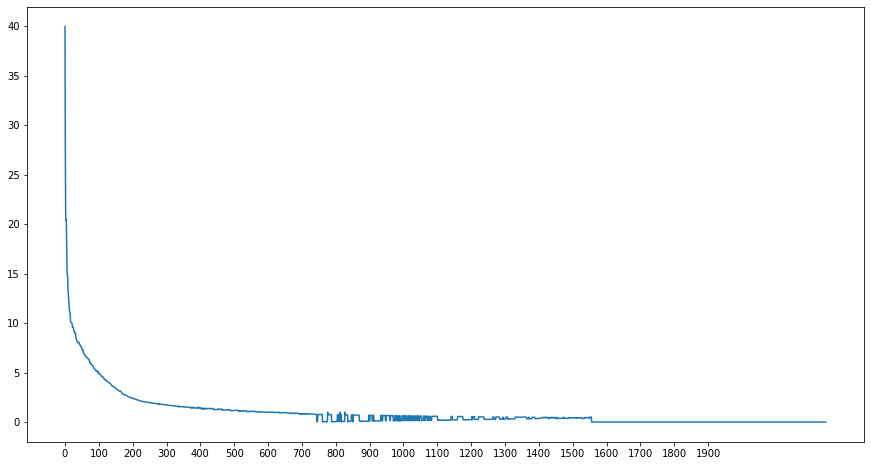

In [714]:
# Print scree plot
plt.figure(figsize=(15, 8))
plt.plot(eig_val_cov)
plt.xticks(np.arange(0, 2000, step=100))
plt.show()

In [715]:
# Dimensionality reduction using PCA
pca = PCA(n_components=200)
netflix_category_cast_pca = pca.fit_transform(netflix_category_cast_std)

In [716]:
clusters = range(2, 76)

for cluster in clusters:

    # Number of clusters
    print('Number of clusters: {}'.format(str(cluster)))

    # Define KMeans
    kmeans = KMeans(n_clusters=cluster)

    # Fit model
    kmeans.fit(netflix_category_cast_pca)

    # Predictions
    kmeans_predictions = kmeans.predict(netflix_category_cast_pca)

    # Metrics
    score(netflix_category_cast_pca, kmeans_predictions)

Number of clusters: 2
Silhouette Score is 0.9515041111137474
Number of clusters: 3
Silhouette Score is 0.9327420561061792
Number of clusters: 4
Silhouette Score is 0.9226754376964097
Number of clusters: 5
Silhouette Score is 0.9113790616205234
Number of clusters: 6
Silhouette Score is 0.8721391571197886
Number of clusters: 7
Silhouette Score is 0.8977673454670497
Number of clusters: 8
Silhouette Score is 0.7918955113463925
Number of clusters: 9
Silhouette Score is 0.8983848031762903
Number of clusters: 10
Silhouette Score is 0.8810953522313235
Number of clusters: 11
Silhouette Score is 0.887808077740322
Number of clusters: 12
Silhouette Score is 0.8050893797350964
Number of clusters: 13
Silhouette Score is 0.8954648898196532
Number of clusters: 14
Silhouette Score is 0.8874287804617229
Number of clusters: 15
Silhouette Score is 0.8884632011751505
Number of clusters: 16
Silhouette Score is 0.762942624125883
Number of clusters: 17
Silhouette Score is 0.8889866021767493
Number of clusters

### Hierarchical

In [717]:
# Agglomerative clustering (complete)
complete_cosine = AgglomerativeClustering(linkage='complete', affinity='cosine')

# Fit and predictions
complete_cosine_predictions = complete_cosine.fit_predict(netflix_category_cast_pca)

# Metrics
score(netflix_category_cast_pca, complete_cosine_predictions)

Silhouette Score is 0.13775382146693257


In [718]:
# Agglomerative clustering (complete)
complete_manhattan = AgglomerativeClustering(linkage='complete', affinity='manhattan')

# Fit and predictions
complete_manhattan_predictions = complete_manhattan.fit_predict(netflix_category_cast_pca)

# Metrics
score(netflix_category_cast_pca, complete_manhattan_predictions)

Silhouette Score is 0.8012813808476705


In [719]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(netflix_category_cast_pca)

# Metrics
score(netflix_category_cast_pca, ward_predictions)

Silhouette Score is 0.9515041111137474


In [720]:
# Agglomerative clustering (average)
average_cosine = AgglomerativeClustering(linkage='average', affinity='cosine')

# Fit and predictions
average_cosine_predictions = average_cosine.fit_predict(netflix_category_cast_pca)

# Metrics
score(netflix_category_cast_pca, average_cosine_predictions)

Silhouette Score is 0.18408145530042375


In [758]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(netflix_category_cast_pca)

# Metrics
score(netflix_category_cast_pca, average_manhattan_predictions)

Silhouette Score is 0.8570648103564082


### Density-based Spatial Clustering of Applications with Noise (DBSCAN) 

In [722]:
epsilon = range(1, 6, 1)
samples = range(2, 12, 1)

for eps in epsilon:
    
    # Epsilon number
    print('Epsilon: {}'.format(str(eps)))

    for sample in samples:
    
        # Number of samples
        print('Number of samples: {}'.format(str(sample)))

        # Define DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=sample)

        # Fit and predictions
        dbscan_predictions = dbscan.fit_predict(netflix_category_cast_pca)
    
        score(netflix_category_cast_pca, dbscan_predictions)

Epsilon: 1
Number of samples: 2
Silhouette Score is -0.11278458469633205
Number of samples: 3
Silhouette Score is -0.15042458030450165
Number of samples: 4
Silhouette Score is -0.16729945025039178
Number of samples: 5
Silhouette Score is -0.17047063516638478
Number of samples: 6
Silhouette Score is -0.17770538002092853
Number of samples: 7
Silhouette Score is -0.18529907654859848
Number of samples: 8
Silhouette Score is -0.1935843698572761
Number of samples: 9
Silhouette Score is -0.19818156265043205
Number of samples: 10
Silhouette Score is -0.20757353045901333
Number of samples: 11
Silhouette Score is -0.21828779980765423
Epsilon: 2
Number of samples: 2
Silhouette Score is -0.13141116226806643
Number of samples: 3
Silhouette Score is -0.12440302740617454
Number of samples: 4
Silhouette Score is -0.10999299170982703
Number of samples: 5
Silhouette Score is -0.1212002485611596
Number of samples: 6
Silhouette Score is -0.12604114281632545
Number of samples: 7
Silhouette Score is -0.1187

### Gaussian Mixture Models (GMM)

In [723]:
components = range(2, 31)

for component in components:
    
    # Number of components
    print('Number of components: {}'.format(str(component)))

    # Define GMM
    gmm = GaussianMixture(n_components=component)

    # Fit and predictions
    gmm_predictions = gmm.fit_predict(netflix_category_cast_pca)
    
    score(netflix_category_cast_pca, gmm_predictions)

Number of components: 2
Silhouette Score is 0.8654177964530336
Number of components: 3
Silhouette Score is 0.815496075853329
Number of components: 4
Silhouette Score is 0.904649218875693
Number of components: 5
Silhouette Score is 0.9050033929510903
Number of components: 6
Silhouette Score is 0.8900663576411729
Number of components: 7
Silhouette Score is 0.8942988915883437
Number of components: 8
Silhouette Score is 0.7580733473991801
Number of components: 9
Silhouette Score is 0.8800519051370927
Number of components: 10
Silhouette Score is -0.32517643817468034
Number of components: 11
Silhouette Score is 0.7590887824336745
Number of components: 12
Silhouette Score is 0.23172823799709333
Number of components: 13
Silhouette Score is 0.8688636558385702
Number of components: 14
Silhouette Score is 0.30035477205153044
Number of components: 15
Silhouette Score is 0.1969617157969383
Number of components: 16
Silhouette Score is 0.8695600794871422
Number of components: 17
Silhouette Score is 0

In [ ]:
# Define KMeans
kmeans = KMeans(n_clusters=2)

# Fit model
kmeans.fit(netflix_category_cast_pca)

# Predictions
kmeans_predictions = kmeans.predict(netflix_category_cast_pca)

# Metrics
score(netflix_category_cast_pca, kmeans_predictions)

### Category, Keyword and Cast

In [724]:
netflix_category_keyword_cast = netflix.copy()
netflix_category_keyword_cast = pd.concat([netflix_category_keyword_cast, netflix_show_categories], axis=1)
netflix_category_keyword_cast = pd.concat([netflix_category_keyword_cast, netflix_show_description], axis=1)
netflix_category_keyword_cast = pd.concat([netflix_category_keyword_cast, netflix_show_cast], axis=1)
netflix_category_keyword_cast = netflix_category_keyword_cast.drop(['cast', 'listed_in', 'description'], axis=1)

In [725]:
netflix_category_keyword_cast.head()

,date_added,TV Show,action & adventure,anime features,anime series,british tv shows,children & family movies,classic & cult tv,classic movies,comedies,crime tv shows,cult movies,documentaries,docuseries,dramas,faith & spirituality,horror movies,independent movies,international movies,international tv shows,kids' tv,korean tv shows,lgbtq movies,movies,music & musicals,reality tv,romantic movies,romantic tv shows,sci-fi & fantasy,science & nature tv,spanish-language tv shows,sports movies,stand-up comedy,stand-up comedy & talk shows,teen tv shows,thrillers,tv action & adventure,tv comedies,tv dramas,tv horror,tv mysteries,tv sci-fi & fantasy,tv shows,tv thrillers,must,find,two,take,life,cop,young,help,agent,team,ninja,naruto,year,demon,save,group,world,guts,student,mysterious,girl,force,fight,new,friend,series,london,crime,home,family,animal,christmas,make,british,run,town,character,years,returns,woman,war,teen,american,man,love,detective,murder,police,takes,killer,three,day,one,live,plan,documentary,film,explore,career,history,documentary series,travel,stories,father,word,story,faith,god,former,begin,house,horror,turn,adventure,evil,fun,korea,gay,pocoyo,holiday,star,true,musical,music,band,fall,host,compete,show,pop,prize,relationship,romance,earth,discover,human,planet,natural,creature,survive,inside,mexico,spain,drug,sport,soccer,player,boxer,become,comedian,comic,stand,stand special,comedy,special,share,guest,celebrity,four,high school,club,school,classmate,high,city,mission,dark,past,ghost,secret,power,crew,space,painting,bob,ross,wet,hit,political,anthology,brother,aamir khan,aarna sharma,aaron hale,aaron himelstein,aaron paul,aaron yan,aaron yoo,aarya dharmchand kumar,aaryansh malviya,abby trott,abdelaziz n'mila,abdelilah wahbi,abhay deol,abigail adriano,adam bartley,adam copeland,adam dimarco,adam mayfield,adam sandler,adam scott,adewale akinnuoye-agbaje,adi khalefa,adib alkhalidey,adil hussain,adina porter,aditi arya,aditi mittal,adrian holmes,adrian petriw,adriana arango,adriana barraza,adriana ozores,adriano zumbo,adrien brody,adrián lastra,afonso padilha,agathe bonitzer,agnes wang,ahmed hatem,ahn jae-wook,ahna o'reilly,ai kayano,aida rodriguez,aissatou diop,ait youssef youssef,aitana sánchez-gijón,aj bowen,ajay devgn,aki toyosaki,akio otsuka,akira kamiya,aksel hennie,akshay kumar,akshay oberoi,akshaye khanna,al tantay,alaina huffman,alan dale,alanna masterson,alba flores,alban lenoir,alberto ajaka,alberto cardeño,alberto guerra,alberto jiménez,...,stefania lavie owen,stephen fry,stephen mangan,steve blum,steve tientcheu,steve zahn,steven m. porter,steven skyler,steven weber,steven yeun,stijn van opstal,stone yang,stéphane debac,stéphane pitti,subaru kimura,subodh bhave,sue perkins,sultan köroğlu kılıç,sumire uesaka,sunanta yoonniyom,sung dong-il,supanart jittaleela,supoj chancharoen,supriya joshi,suresh oberoi,sushar manaying,sushil pandey,sutatta udomsilp,suzanne rault-balet,suzi dougherty,sylvester groth,sylvester stallone,sylvia wang,sébastien chassagne,t.j. miller,taapsee pannu,tabitha st. germain,tae-hwan kang,tae-im lee,tae-yeol jeon,taecyeon,taissa farmiga,takahiro azuma,takahiro sakurai,takashi yamanaka,takehito koyasu,takeo chii,talia shire,tamannaah bhatia,tamar novas,tamsin greig,tan france,tan hau yen,tania dutel,tanishaa mukerji,tannishtha chatterjee,tara pacheco,tara strong,taraji p. henson,tasuku hatanaka,tatchapol thitiapichai,tay ping hui,tayam amar,taylor tomlinson,ted danson,teddy sears,teeradon supapunpinyo,teetatch ratanasritai,teresa palmer,terry crews,terry gilliam,terry jones,teté espinoza,thanapatpisal sananthachat,thanawetch siriwattanakul,thanyanan pipatchaisiri,thati lopes,theo rossi,thiago ventura,thiti mahayotaruk,thitinan khlangphet,thomas elms,thomas haden church,thomas mann,tia lee,tian zhi-jie,tiffany haddish,tijmen govaerts,tillotama shome,tim dillon,tim downie,tim lagasse,tim roth,time winters,timothy hutton,tina fey,tinnu anand,tiphaine daviot,toinette laquiere,tom audenaert,tom h

In [726]:
# Standardize
scaler = StandardScaler()
netflix_category_keyword_cast_std = scaler.fit_transform(netflix_category_keyword_cast)

# Transpose X
Xt = netflix_category_keyword_cast_std.T

# Covariance
Cx = np.cov(Xt)

# Calculate eigenvalues and eigenvectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

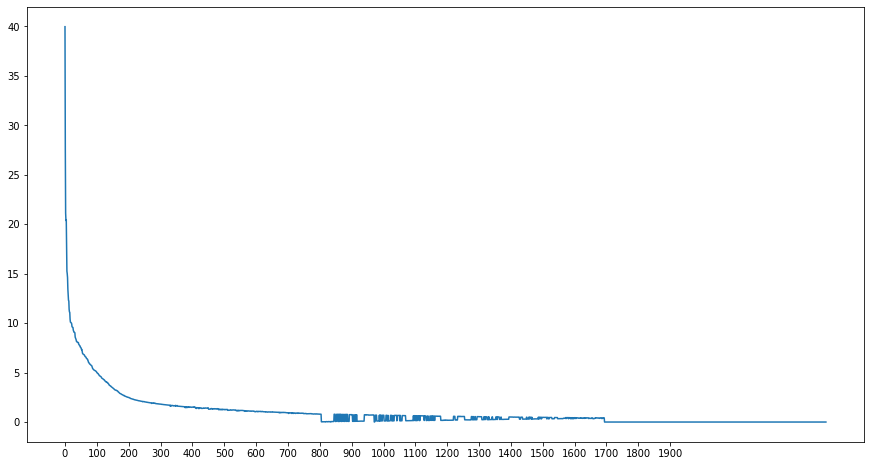

In [727]:
# Print scree plot
plt.figure(figsize=(15, 8))
plt.plot(eig_val_cov)
plt.xticks(np.arange(0, 2000, step=100))
plt.show()

In [728]:
# Dimensionality reduction using PCA
pca = PCA(n_components=200)
netflix_category_keyword_cast_pca = pca.fit_transform(netflix_category_keyword_cast_std)

In [729]:
clusters = range(2, 76)

for cluster in clusters:

    # Number of clusters
    print('Number of clusters: {}'.format(str(cluster)))

    # Define KMeans
    kmeans = KMeans(n_clusters=cluster)

    # Fit model
    kmeans.fit(netflix_category_keyword_cast_pca)

    # Predictions
    kmeans_predictions = kmeans.predict(netflix_category_keyword_cast_pca)

    # Metrics
    score(netflix_category_keyword_cast_pca, kmeans_predictions)

Number of clusters: 2
Silhouette Score is 0.9495956356421349
Number of clusters: 3
Silhouette Score is 0.9042708820381249
Number of clusters: 4
Silhouette Score is 0.6291509880437678
Number of clusters: 5
Silhouette Score is 0.892706113528843
Number of clusters: 6
Silhouette Score is 0.9038051226157799
Number of clusters: 7
Silhouette Score is 0.8767081214747707
Number of clusters: 8
Silhouette Score is 0.7476592878691046
Number of clusters: 9
Silhouette Score is 0.8847557534142994
Number of clusters: 10
Silhouette Score is 0.8884595257010339
Number of clusters: 11
Silhouette Score is 0.8616041503525058
Number of clusters: 12
Silhouette Score is 0.893118949133017
Number of clusters: 13
Silhouette Score is 0.8822483306243042
Number of clusters: 14
Silhouette Score is 0.030957906365761362
Number of clusters: 15
Silhouette Score is 0.8832267056646403
Number of clusters: 16
Silhouette Score is 0.8501384347556667
Number of clusters: 17
Silhouette Score is 0.8751165877333374
Number of cluste

### Hierarchical

In [730]:
# Agglomerative clustering (complete)
complete_cosine = AgglomerativeClustering(linkage='complete', affinity='cosine')

# Fit and predictions
complete_cosine_predictions = complete_cosine.fit_predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, complete_cosine_predictions)

Silhouette Score is 0.06832391685750255


In [731]:
# Agglomerative clustering (complete)
complete_manhattan = AgglomerativeClustering(linkage='complete', affinity='manhattan')

# Fit and predictions
complete_manhattan_predictions = complete_manhattan.fit_predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, complete_manhattan_predictions)

Silhouette Score is 0.7535427626435431


In [732]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, ward_predictions)

Silhouette Score is 0.9495956356421349


In [733]:
# Agglomerative clustering (average)
average_cosine = AgglomerativeClustering(linkage='average', affinity='cosine')

# Fit and predictions
average_cosine_predictions = average_cosine.fit_predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, average_cosine_predictions)

Silhouette Score is 0.13226318794495964


In [759]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, average_manhattan_predictions)

Silhouette Score is 0.8512006864669567


### Density-based Spatial Clustering of Applications with Noise (DBSCAN) 

In [735]:
epsilon = range(1, 6, 1)
samples = range(2, 12, 1)

for eps in epsilon:
    
    # Epsilon number
    print('Epsilon: {}'.format(str(eps)))

    for sample in samples:
    
        # Number of samples
        print('Number of samples: {}'.format(str(sample)))

        # Define DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=sample)

        # Fit and predictions
        dbscan_predictions = dbscan.fit_predict(netflix_category_keyword_cast_pca)
    
        score(netflix_category_keyword_cast_pca, dbscan_predictions)

Epsilon: 1
Number of samples: 2
Silhouette Score is -0.4648252166534151
Number of samples: 3
Silhouette Score is -0.49118017490129623
Number of samples: 4
Silhouette Score is -0.5067972582833934
Number of samples: 5
Silhouette Score is -0.5134987802828224
Number of samples: 6
Silhouette Score is -0.5226835725955045
Number of samples: 7
Silhouette Score is -0.5268661357748949
Number of samples: 8
Silhouette Score is -0.5275789482632635
Number of samples: 9
Silhouette Score is -0.5264850307868972
Number of samples: 10
Silhouette Score is -0.5286086505839399
Number of samples: 11
Silhouette Score is -0.5320865292692462
Epsilon: 2
Number of samples: 2
Silhouette Score is -0.378635381158184
Number of samples: 3
Silhouette Score is -0.36464297751517716
Number of samples: 4
Silhouette Score is -0.367737742232264
Number of samples: 5
Silhouette Score is -0.3693848410185511
Number of samples: 6
Silhouette Score is -0.3739259223573195
Number of samples: 7
Silhouette Score is -0.352690580293795
N

### Gaussian Mixture Models (GMM)

In [736]:
components = range(2, 31)

for component in components:
    
    # Number of components
    print('Number of components: {}'.format(str(component)))

    # Define GMM
    gmm = GaussianMixture(n_components=component)

    # Fit and predictions
    gmm_predictions = gmm.fit_predict(netflix_category_keyword_cast_pca)
    
    score(netflix_category_keyword_cast_pca, gmm_predictions)

Number of components: 2
Silhouette Score is 0.5350792244611002
Number of components: 3
Silhouette Score is 0.9070770407060875
Number of components: 4
Silhouette Score is 0.8524362575700433
Number of components: 5
Silhouette Score is 0.9096809560169415
Number of components: 6
Silhouette Score is 0.7918153756029032
Number of components: 7
Silhouette Score is 0.762136873872341
Number of components: 8
Silhouette Score is 0.7886447848662536
Number of components: 9
Silhouette Score is 0.5952223926539917
Number of components: 10
Silhouette Score is 0.7688754677098409
Number of components: 11
Silhouette Score is 0.5390450349021215
Number of components: 12
Silhouette Score is 0.8885104932825414
Number of components: 13
Silhouette Score is 0.7671374381377785
Number of components: 14
Silhouette Score is 0.7503839767798325
Number of components: 15
Silhouette Score is 0.7098250548394148
Number of components: 16
Silhouette Score is 0.7765927220193515
Number of components: 17
Silhouette Score is 0.60

In [ ]:
# Define KMeans
kmeans = KMeans(n_clusters=2)

# Fit model
kmeans.fit(netflix_category_keyword_cast_pca)

# Predictions
kmeans_predictions = kmeans.predict(netflix_category_keyword_cast_pca)

# Metrics
score(netflix_category_keyword_cast_pca, kmeans_predictions)

### Category, Country, Keyword and Cast

In [737]:
netflix_category_country_keyword_cast = netflix.copy()
netflix_category_country_keyword_cast = pd.concat([netflix_category_country_keyword_cast, netflix_show_categories], axis=1)
netflix_category_country_keyword_cast = pd.concat([netflix_category_country_keyword_cast, netflix_show_countries], axis=1)
netflix_category_country_keyword_cast = pd.concat([netflix_category_country_keyword_cast, netflix_show_description], axis=1)
netflix_category_country_keyword_cast = pd.concat([netflix_category_country_keyword_cast, netflix_show_cast], axis=1)
netflix_category_country_keyword_cast = netflix_category_country_keyword_cast.drop(['country', 'cast', 'listed_in', 'description'], axis=1)

In [738]:
netflix_category_country_keyword_cast.head()

,date_added,TV Show,action & adventure,anime features,anime series,british tv shows,children & family movies,classic & cult tv,classic movies,comedies,crime tv shows,cult movies,documentaries,docuseries,dramas,faith & spirituality,horror movies,independent movies,international movies,international tv shows,kids' tv,korean tv shows,lgbtq movies,movies,music & musicals,reality tv,romantic movies,romantic tv shows,sci-fi & fantasy,science & nature tv,spanish-language tv shows,sports movies,stand-up comedy,stand-up comedy & talk shows,teen tv shows,thrillers,tv action & adventure,tv comedies,tv dramas,tv horror,tv mysteries,tv sci-fi & fantasy,tv shows,tv thrillers,afghanistan,albania,argentina,australia,austria,azerbaijan,bangladesh,belgium,bermuda,brazil,bulgaria,cambodia,canada,cayman islands,chile,china,colombia,croatia,cuba,cyprus,czech republic,denmark,dominican republic,east germany,ecuador,egypt,finland,france,georgia,germany,ghana,greece,guatemala,hong kong,hungary,iceland,india,indonesia,iran,iraq,ireland,israel,italy,japan,jordan,kenya,kuwait,latvia,lebanon,liechtenstein,luxembourg,malawi,malaysia,malta,mauritius,mexico,montenegro,morocco,nepal,netherlands,new zealand,nicaragua,nigeria,norway,pakistan,panama,paraguay,peru,philippines,poland,portugal,qatar,romania,russia,saudi arabia,senegal,serbia,singapore,slovakia,slovenia,somalia,south africa,south korea,soviet union,spain,sri lanka,sudan,sweden,switzerland,syria,taiwan,thailand,turkey,ukraine,united arab emirates,united kingdom,united states,unknown,uruguay,vatican city,venezuela,vietnam,west germany,must,find,two,take,life,cop,young,help,agent,team,ninja,naruto,year,demon,save,group,world,guts,student,mysterious,girl,force,fight,new,friend,series,london,crime,home,family,animal,christmas,make,british,run,town,character,years,returns,woman,war,teen,american,man,love,detective,murder,police,takes,killer,three,day,one,live,plan,documentary,film,explore,career,history,documentary series,travel,stories,father,word,story,faith,god,former,begin,house,horror,turn,adventure,evil,fun,korea,gay,pocoyo,holiday,star,true,musical,music,band,fall,host,compete,show,pop,prize,relationship,romance,earth,discover,human,planet,natural,creature,survive,inside,mexico,spain,...,stefania lavie owen,stephen fry,stephen mangan,steve blum,steve tientcheu,steve zahn,steven m. porter,steven skyler,steven weber,steven yeun,stijn van opstal,stone yang,stéphane debac,stéphane pitti,subaru kimura,subodh bhave,sue perkins,sultan köroğlu kılıç,sumire uesaka,sunanta yoonniyom,sung dong-il,supanart jittaleela,supoj chancharoen,supriya joshi,suresh oberoi,sushar manaying,sushil pandey,sutatta udomsilp,suzanne rault-balet,suzi dougherty,sylvester groth,sylvester stallone,sylvia wang,sébastien chassagne,t.j. miller,taapsee pannu,tabitha st. germain,tae-hwan kang,tae-im lee,tae-yeol jeon,taecyeon,taissa farmiga,takahiro azuma,takahiro sakurai,takashi yamanaka,takehito koyasu,takeo chii,talia shire,tamannaah bhatia,tamar novas,tamsin greig,tan france,tan hau yen,tania dutel,tanishaa mukerji,tannishtha chatterjee,tara pacheco,tara strong,taraji p. henson,tasuku hatanaka,tatchapol thitiapichai,tay ping hui,tayam amar,taylor tomlinson,ted danson,teddy sears,teeradon supapunpinyo,teetatch ratanasritai,teresa palmer,terry crews,terry gilliam,terry jones,teté espinoza,thanapatpisal sananthachat,thanawetch siriwattanakul,thanyanan pipatchaisiri,thati lopes,theo rossi,thiago ventura,thiti mahayotaruk,thitinan khlangphet,thomas elms,thomas haden church,thomas mann,tia lee,tian zhi-jie,tiffany haddish,tijmen govaerts,tillotama shome,tim dillon,tim downie,tim lagasse,tim roth,time winters,timothy hutton,tina fey,tinnu anand,tiphaine daviot,toinette laquiere,tom audenaert,tom hanks,tom hardy,tom kenny,tom wilkinson,tomer sisley,tommy vasquez,tomokazu sugita,tony burton,tony genaro,tony goldwyn,tony hale,tony todd,topher grace,toshiki masuda,toto vega,trace beaulieu,tracey ashley,tracie thoms,tracy ann oberman,treat wi

In [739]:
# Standardize data
scaler = StandardScaler()
netflix_category_country_keyword_cast_std = scaler.fit_transform(netflix_category_country_keyword_cast)

# Transpose X
Xt = netflix_category_country_keyword_cast_std.T

# Covariance
Cx = np.cov(Xt)

# Calculate eigenvalues and eigenvectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

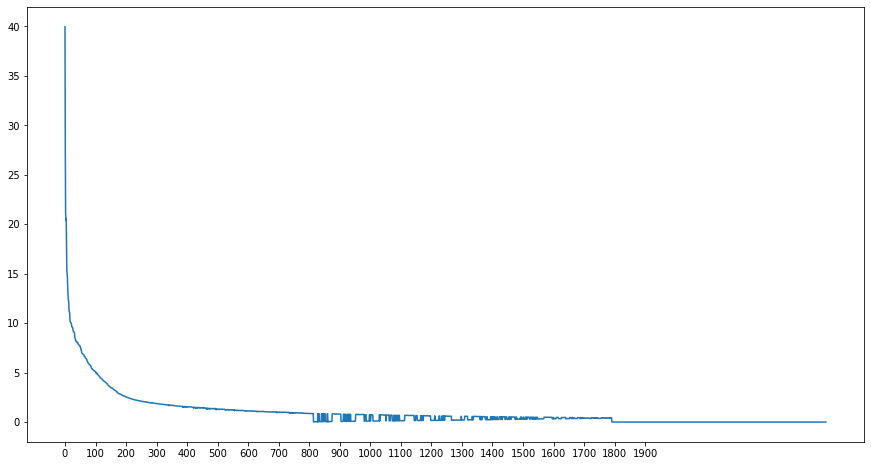

In [740]:
# Print scree plot
plt.figure(figsize=(15, 8))
plt.plot(eig_val_cov)
plt.xticks(np.arange(0, 2000, step=100))
plt.show()

In [741]:
# Dimensionality reduction using PCA
pca = PCA(n_components=200)
netflix_category_country_keyword_cast_pca = pca.fit_transform(netflix_category_country_keyword_cast_std)

In [742]:
clusters = range(2, 76)

for cluster in clusters:

    # Number of clusters
    print('Number of clusters: {}'.format(str(cluster)))

    # Define KMeans
    kmeans = KMeans(n_clusters=cluster)

    # Fit model
    kmeans.fit(netflix_category_country_keyword_cast_pca)

    # Predictions
    kmeans_predictions = kmeans.predict(netflix_category_country_keyword_cast_pca)

    # Metrics
    score(netflix_category_country_keyword_cast_pca, kmeans_predictions)

Number of clusters: 2
Silhouette Score is 0.9162514532531263
Number of clusters: 3
Silhouette Score is 0.9282595001424021
Number of clusters: 4
Silhouette Score is 0.8742715138047591
Number of clusters: 5
Silhouette Score is 0.8084131741389282
Number of clusters: 6
Silhouette Score is 0.861955019539776
Number of clusters: 7
Silhouette Score is 0.8551265260009129
Number of clusters: 8
Silhouette Score is 0.7964974545680354
Number of clusters: 9
Silhouette Score is 0.891307182727383
Number of clusters: 10
Silhouette Score is 0.812146311935474
Number of clusters: 11
Silhouette Score is 0.9015130745871459
Number of clusters: 12
Silhouette Score is 0.8139636460199958
Number of clusters: 13
Silhouette Score is 0.8663883116415946
Number of clusters: 14
Silhouette Score is 0.2602723334900444
Number of clusters: 15
Silhouette Score is 0.7928700122633079
Number of clusters: 16
Silhouette Score is 0.8806287667186918
Number of clusters: 17
Silhouette Score is 0.27125695071373185
Number of clusters

### Hierarchical

In [743]:
# Agglomerative clustering (complete)
complete_cosine = AgglomerativeClustering(linkage='complete', affinity='cosine')

# Fit and predictions
complete_cosine_predictions = complete_cosine.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, complete_cosine_predictions)

Silhouette Score is 0.057190390905795044


In [744]:
# Agglomerative clustering (complete)
complete_manhattan = AgglomerativeClustering(linkage='complete', affinity='manhattan')

# Fit and predictions
complete_manhattan_predictions = complete_manhattan.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, complete_manhattan_predictions)

Silhouette Score is 0.8088151886286589


In [745]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, ward_predictions)

Silhouette Score is 0.948274887484708


In [746]:
# Agglomerative clustering (average)
average_cosine = AgglomerativeClustering(linkage='average', affinity='cosine')

# Fit and predictions
average_cosine_predictions = average_cosine.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, average_cosine_predictions)

Silhouette Score is 0.1437453617155146


In [760]:
# Agglomerative clustering (average)
average_manhattan = AgglomerativeClustering(linkage='average', affinity='manhattan')

# Fit and predictions
average_manhattan_predictions = average_manhattan.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, average_manhattan_predictions)

Silhouette Score is 0.8467288097398605


### Density-based Spatial Clustering of Applications with Noise (DBSCAN) 

In [748]:
epsilon = range(1, 6, 1)
samples = range(2, 12, 1)

for eps in epsilon:
    
    # Epsilon number
    print('Epsilon: {}'.format(str(eps)))

    for sample in samples:
    
        # Number of samples
        print('Number of samples: {}'.format(str(sample)))

        # Define DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=sample)

        # Fit and predictions
        dbscan_predictions = dbscan.fit_predict(netflix_category_country_keyword_cast_pca)
    
        score(netflix_category_country_keyword_cast_pca, dbscan_predictions)

Epsilon: 1
Number of samples: 2
Silhouette Score is -0.5266433614365283
Number of samples: 3
Silhouette Score is -0.5510664634938093
Number of samples: 4
Silhouette Score is -0.5619733823259006
Number of samples: 5
Silhouette Score is -0.5661680926800963
Number of samples: 6
Silhouette Score is -0.5720147255731999
Number of samples: 7
Silhouette Score is -0.5748399952595702
Number of samples: 8
Silhouette Score is -0.5700286039887588
Number of samples: 9
Silhouette Score is -0.5713662295195172
Number of samples: 10
Silhouette Score is -0.568106891202398
Number of samples: 11
Silhouette Score is -0.5690060326751387
Epsilon: 2
Number of samples: 2
Silhouette Score is -0.4243932292149031
Number of samples: 3
Silhouette Score is -0.41701559473374644
Number of samples: 4
Silhouette Score is -0.4068338390473818
Number of samples: 5
Silhouette Score is -0.40708570247671316
Number of samples: 6
Silhouette Score is -0.38863713709951775
Number of samples: 7
Silhouette Score is -0.385947829188945

### Gaussian Mixture Models (GMM)

In [749]:
components = range(2, 31)

for component in components:
    
    # Number of components
    print('Number of components: {}'.format(str(component)))

    # Define GMM
    gmm = GaussianMixture(n_components=component)

    # Fit and predictions
    gmm_predictions = gmm.fit_predict(netflix_category_country_keyword_cast_pca)
    
    score(netflix_category_country_keyword_cast_pca, gmm_predictions)

Number of components: 2
Silhouette Score is 0.8859593171516226
Number of components: 3
Silhouette Score is 0.7865667081489741
Number of components: 4
Silhouette Score is 0.9237935833213042
Number of components: 5
Silhouette Score is 0.8906596056253667
Number of components: 6
Silhouette Score is 0.3655316884668351
Number of components: 7
Silhouette Score is 0.7636075507071901
Number of components: 8
Silhouette Score is 0.6682450601713397
Number of components: 9
Silhouette Score is 0.4271775384946789
Number of components: 10
Silhouette Score is 0.5306774691432138
Number of components: 11
Silhouette Score is 0.5307922677195751
Number of components: 12
Silhouette Score is 0.7428919686743362
Number of components: 13
Silhouette Score is 0.7437408367533849
Number of components: 14
Silhouette Score is 0.7485182983941073
Number of components: 15
Silhouette Score is 0.7916420092867602
Number of components: 16
Silhouette Score is 0.7025870223432339
Number of components: 17
Silhouette Score is 0.4

In [745]:
# Agglomerative clustering (ward)
ward_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean')

# Fit and predictions
ward_predictions = ward_cluster.fit_predict(netflix_category_country_keyword_cast_pca)

# Metrics
score(netflix_category_country_keyword_cast_pca, ward_predictions)

Silhouette Score is 0.948274887484708


### Dimensionality Reduction 

I'll be comparing t-SNE and UMAP dimensionality reduction techniques.

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

Perplexity: 40
Number of iteration: 250
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.164s...
[t-SNE] Computed neighbors for 5654 samples in 36.999s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.325485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.763138
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168

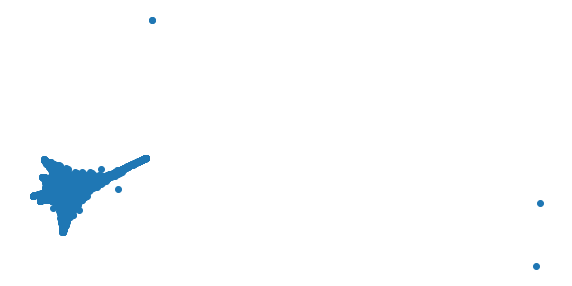

Number of iteration: 275
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.283s...
[t-SNE] Computed neighbors for 5654 samples in 38.951s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.325485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.135643
[t-SNE] KL divergence after 275 iterations: 2.636750


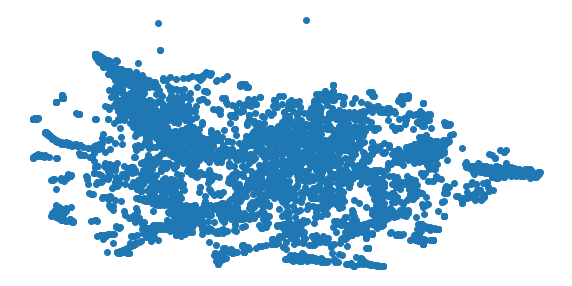

Number of iteration: 300
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.208s...
[t-SNE] Computed neighbors for 5654 samples in 37.469s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.325485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.714951
[t-SNE] KL divergence after 300 iterations: 2.117823


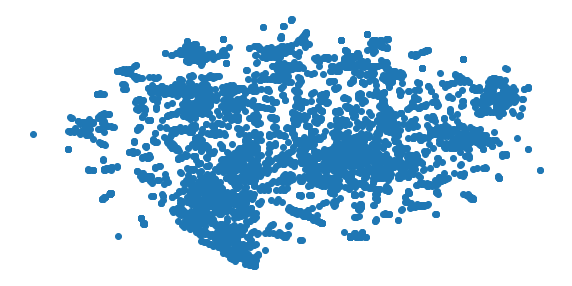

Number of iteration: 325
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.176s...
[t-SNE] Computed neighbors for 5654 samples in 38.007s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.325485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.825378
[t-SNE] KL divergence after 325 iterations: 1.888378


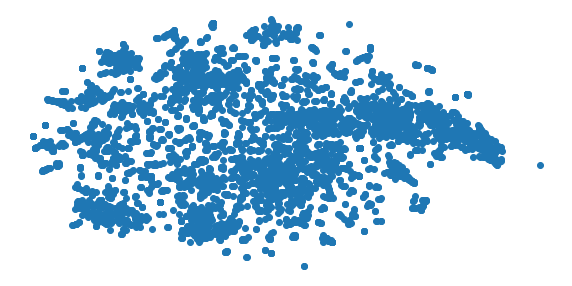

Number of iteration: 350
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.172s...
[t-SNE] Computed neighbors for 5654 samples in 37.851s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.325485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.955414
[t-SNE] KL divergence after 350 iterations: 1.756418


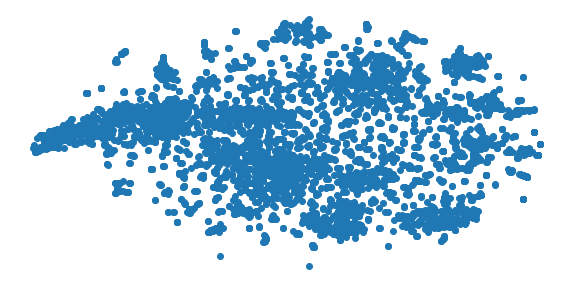

Number of iteration: 375
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.163s...
[t-SNE] Computed neighbors for 5654 samples in 37.989s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.325485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.932045
[t-SNE] KL divergence after 375 iterations: 1.670265


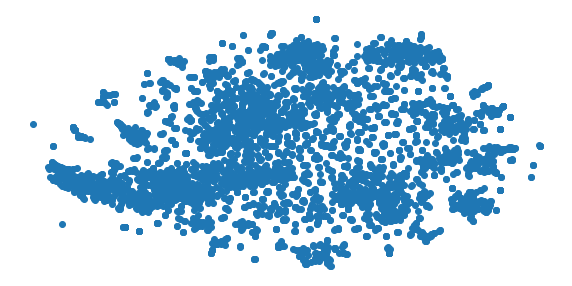

Number of iteration: 400
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.160s...
[t-SNE] Computed neighbors for 5654 samples in 37.336s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.325485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.033943
[t-SNE] KL divergence after 400 iterations: 1.610554


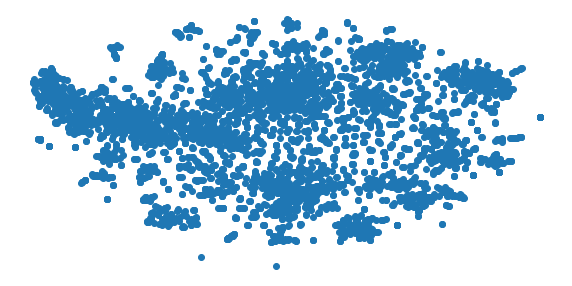

Perplexity: 45
Number of iteration: 250
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.172s...
[t-SNE] Computed neighbors for 5654 samples in 37.810s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.354624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.929092
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168

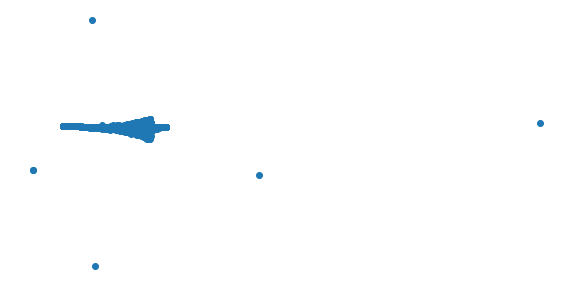

Number of iteration: 275
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.166s...
[t-SNE] Computed neighbors for 5654 samples in 38.227s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.354624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.908752
[t-SNE] KL divergence after 275 iterations: 2.563190


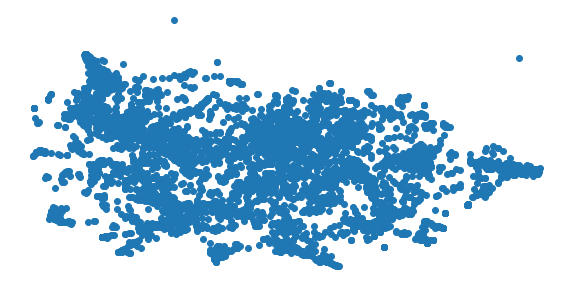

Number of iteration: 300
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.163s...
[t-SNE] Computed neighbors for 5654 samples in 38.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.354624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.031013
[t-SNE] KL divergence after 300 iterations: 2.064077


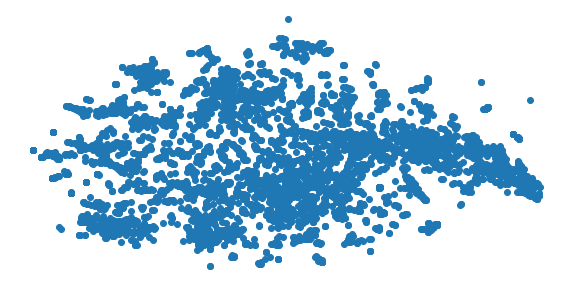

Number of iteration: 325
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.176s...
[t-SNE] Computed neighbors for 5654 samples in 37.670s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.354624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.946877
[t-SNE] KL divergence after 325 iterations: 1.848798


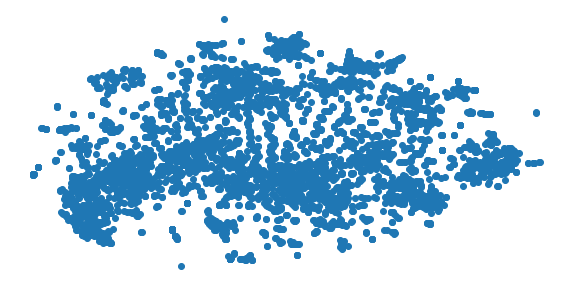

Number of iteration: 350
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.196s...
[t-SNE] Computed neighbors for 5654 samples in 37.996s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.354624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.919006
[t-SNE] KL divergence after 350 iterations: 1.721565


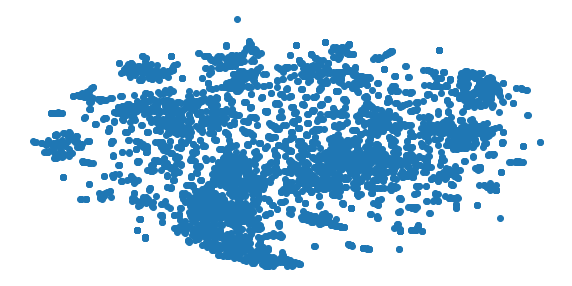

Number of iteration: 375
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.186s...
[t-SNE] Computed neighbors for 5654 samples in 37.702s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.354624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.790741
[t-SNE] KL divergence after 375 iterations: 1.639247


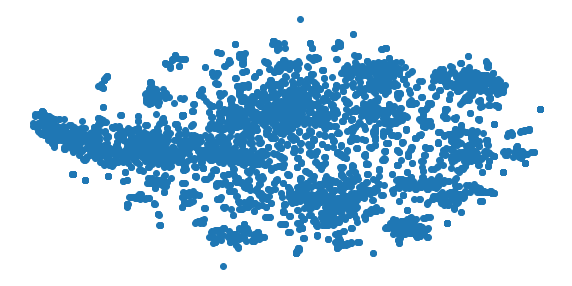

Number of iteration: 400
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.158s...
[t-SNE] Computed neighbors for 5654 samples in 37.571s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.354624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.902405
[t-SNE] KL divergence after 400 iterations: 1.580765


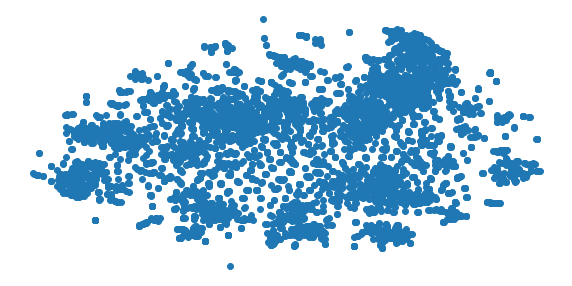

Perplexity: 50
Number of iteration: 250
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.207s...
[t-SNE] Computed neighbors for 5654 samples in 37.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.381236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.990067
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168

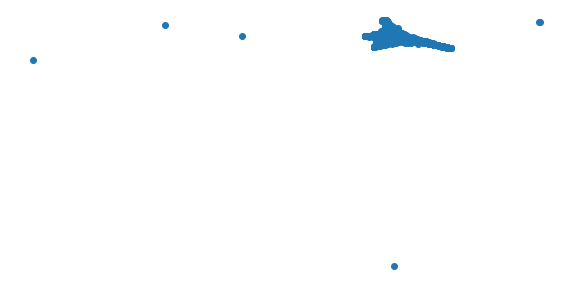

Number of iteration: 275
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.173s...
[t-SNE] Computed neighbors for 5654 samples in 37.303s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.381236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.342056
[t-SNE] KL divergence after 275 iterations: 2.490074


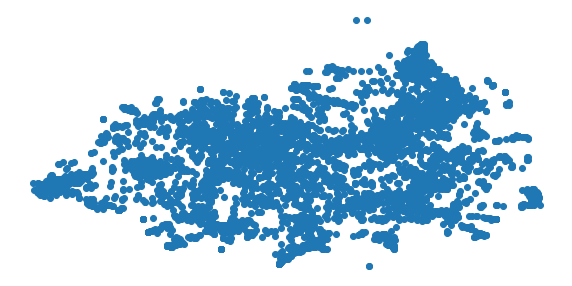

Number of iteration: 300
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.173s...
[t-SNE] Computed neighbors for 5654 samples in 38.313s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.381236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.236275
[t-SNE] KL divergence after 300 iterations: 2.019270


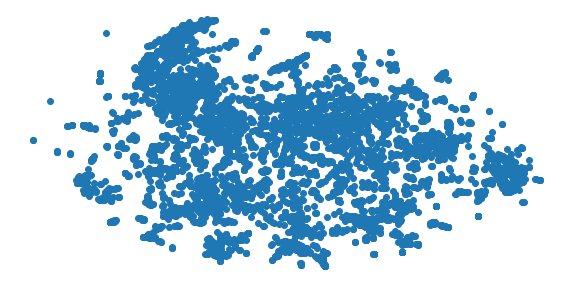

Number of iteration: 325
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.182s...
[t-SNE] Computed neighbors for 5654 samples in 37.756s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.381236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.163422
[t-SNE] KL divergence after 325 iterations: 1.814960


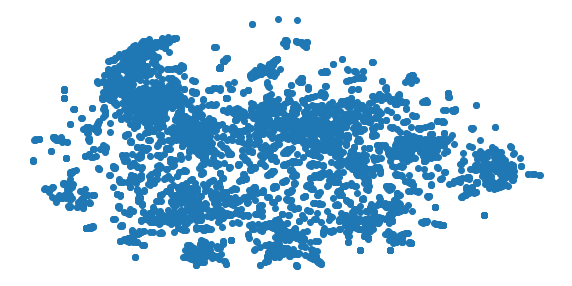

Number of iteration: 350
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.173s...
[t-SNE] Computed neighbors for 5654 samples in 37.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.381236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.184364
[t-SNE] KL divergence after 350 iterations: 1.697721


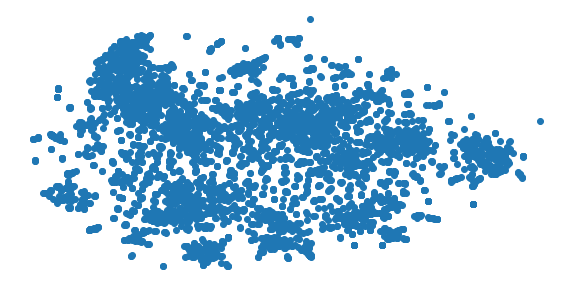

Number of iteration: 375
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.178s...
[t-SNE] Computed neighbors for 5654 samples in 38.578s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.381236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.255302
[t-SNE] KL divergence after 375 iterations: 1.617667


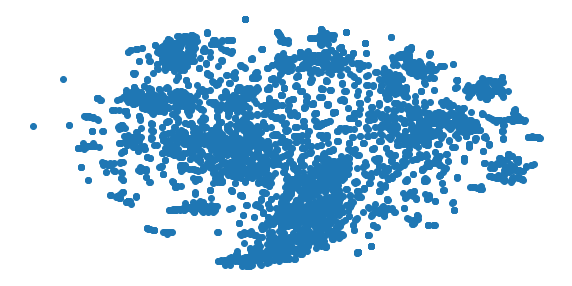

Number of iteration: 400
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.173s...
[t-SNE] Computed neighbors for 5654 samples in 37.271s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.381236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.018639
[t-SNE] KL divergence after 400 iterations: 1.563719


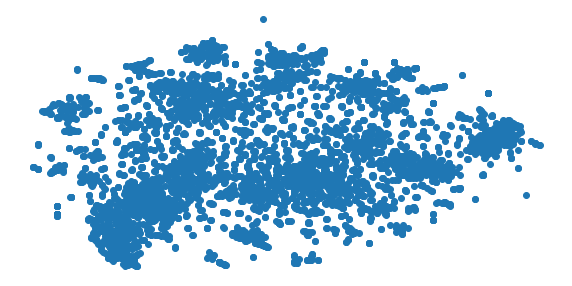

Perplexity: 55
Number of iteration: 250
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.171s...
[t-SNE] Computed neighbors for 5654 samples in 37.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.405886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.487984
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168

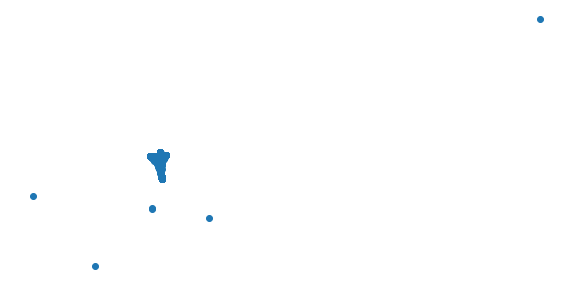

Number of iteration: 275
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.172s...
[t-SNE] Computed neighbors for 5654 samples in 37.557s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.405886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.272057
[t-SNE] KL divergence after 275 iterations: 2.433386


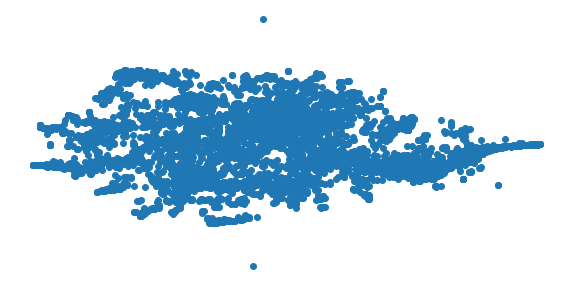

Number of iteration: 300
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.175s...
[t-SNE] Computed neighbors for 5654 samples in 37.515s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.405886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.367439
[t-SNE] KL divergence after 300 iterations: 1.975720


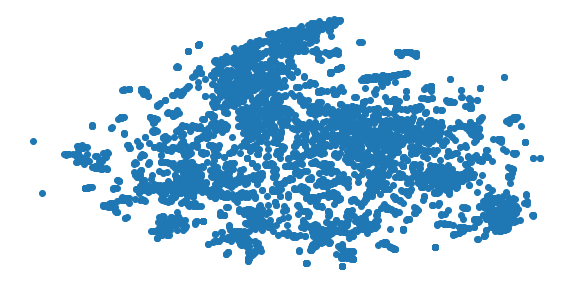

Number of iteration: 325
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.178s...
[t-SNE] Computed neighbors for 5654 samples in 37.339s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.405886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.283623
[t-SNE] KL divergence after 325 iterations: 1.780492


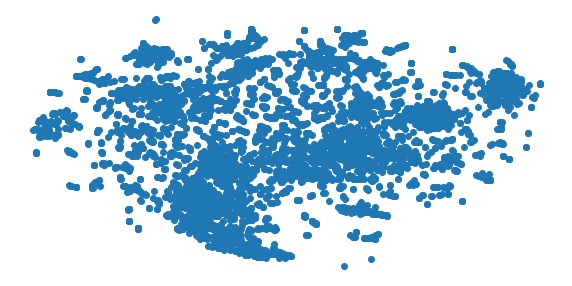

Number of iteration: 350
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.203s...
[t-SNE] Computed neighbors for 5654 samples in 38.962s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.405886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.692406
[t-SNE] KL divergence after 350 iterations: 1.671231


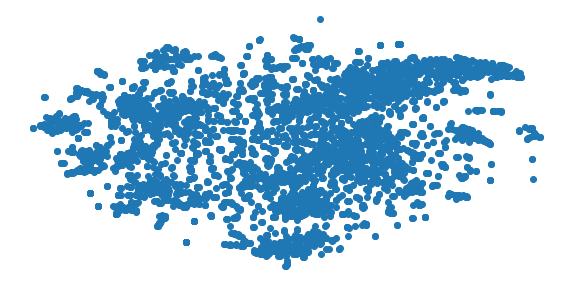

Number of iteration: 375
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.171s...
[t-SNE] Computed neighbors for 5654 samples in 37.976s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.405886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.427826
[t-SNE] KL divergence after 375 iterations: 1.596983


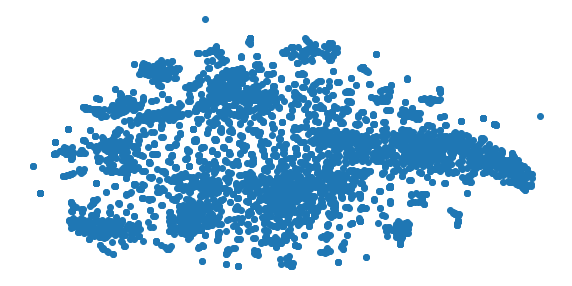

Number of iteration: 400
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.221s...
[t-SNE] Computed neighbors for 5654 samples in 37.596s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.405886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.618637
[t-SNE] KL divergence after 400 iterations: 1.546104


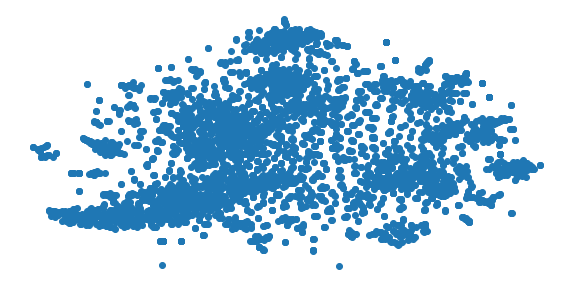

Perplexity: 60
Number of iteration: 250
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.161s...
[t-SNE] Computed neighbors for 5654 samples in 37.254s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.428891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.863518
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168

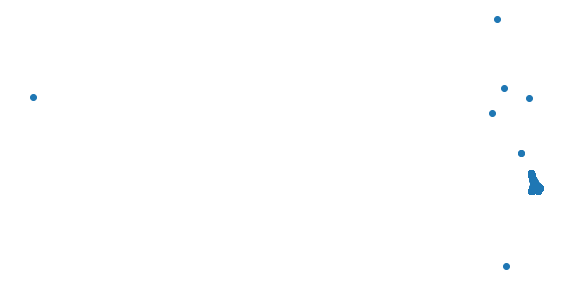

Number of iteration: 275
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.205s...
[t-SNE] Computed neighbors for 5654 samples in 38.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.428891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.156036
[t-SNE] KL divergence after 275 iterations: 2.395529


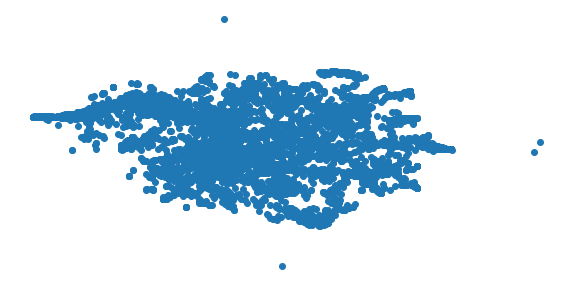

Number of iteration: 300
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.165s...
[t-SNE] Computed neighbors for 5654 samples in 36.339s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.428891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.040619
[t-SNE] KL divergence after 300 iterations: 1.941154


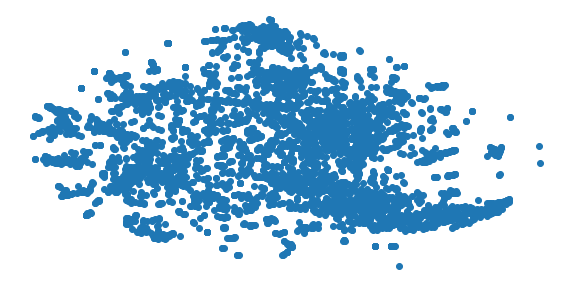

Number of iteration: 325
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.167s...
[t-SNE] Computed neighbors for 5654 samples in 35.981s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.428891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.955605
[t-SNE] KL divergence after 325 iterations: 1.755970


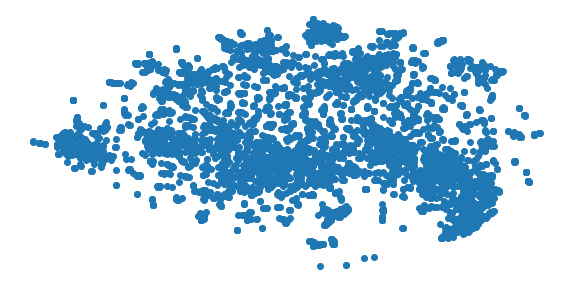

Number of iteration: 350
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.208s...
[t-SNE] Computed neighbors for 5654 samples in 37.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.428891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.562698
[t-SNE] KL divergence after 350 iterations: 1.644367


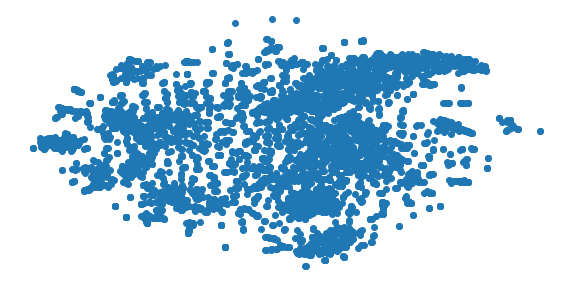

Number of iteration: 375
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.147s...
[t-SNE] Computed neighbors for 5654 samples in 37.520s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.428891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.625870
[t-SNE] KL divergence after 375 iterations: 1.571339


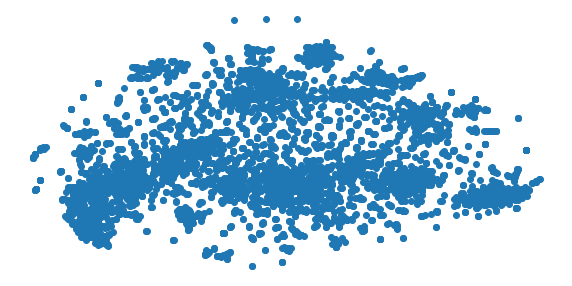

Number of iteration: 400
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5654 samples in 0.183s...
[t-SNE] Computed neighbors for 5654 samples in 37.823s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5654
[t-SNE] Computed conditional probabilities for sample 2000 / 5654
[t-SNE] Computed conditional probabilities for sample 3000 / 5654
[t-SNE] Computed conditional probabilities for sample 4000 / 5654
[t-SNE] Computed conditional probabilities for sample 5000 / 5654
[t-SNE] Computed conditional probabilities for sample 5654 / 5654
[t-SNE] Mean sigma: 1.428891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.040909
[t-SNE] KL divergence after 400 iterations: 1.523558


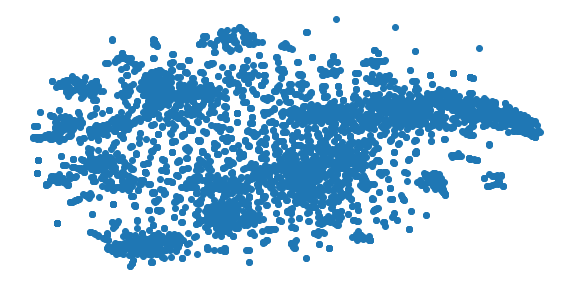

In [445]:
perplexity = [40, 45, 50, 55, 60]
iterations = [250, 275, 300, 325, 350, 375, 400]

for perplex in perplexity:

    print('Perplexity: {}'.format(str(perplex)))   
    
    for iteration in iterations:

        # Number of iterations
        print('Number of iteration: {}'.format(str(iteration)))

        # Define t-SNE
        tsne = TSNE(n_components=2, verbose=1, perplexity=perplex, n_iter=iteration)

        # Retrieve components
        tsne_results = tsne.fit_transform(X_pca)

        # Plot visual
        plt.figure(figsize=(10,5))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()

### Uniform Manifold Approximation and Projection (UMAP) 

Min Dist: 0.3
Number of neighbors: 3


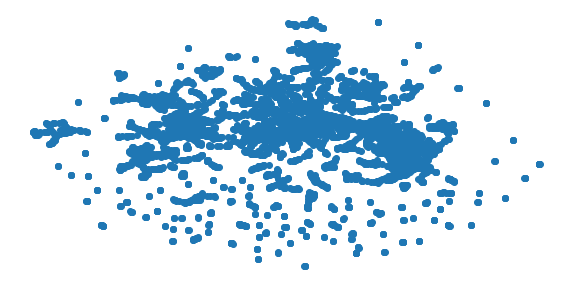

Number of neighbors: 4


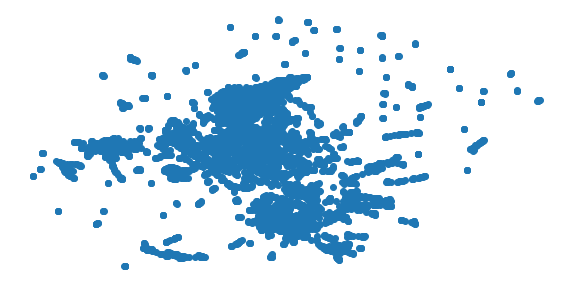

Number of neighbors: 5


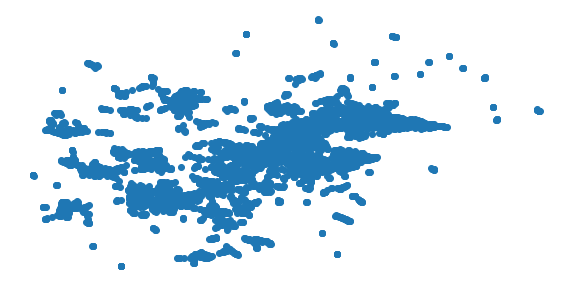

Number of neighbors: 6


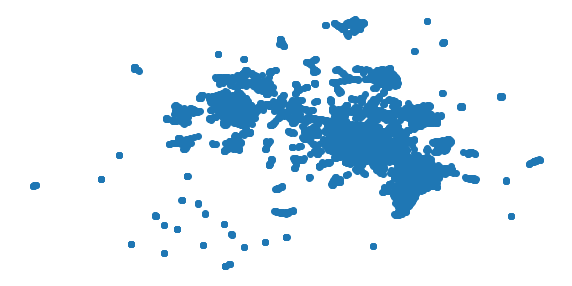

Number of neighbors: 7


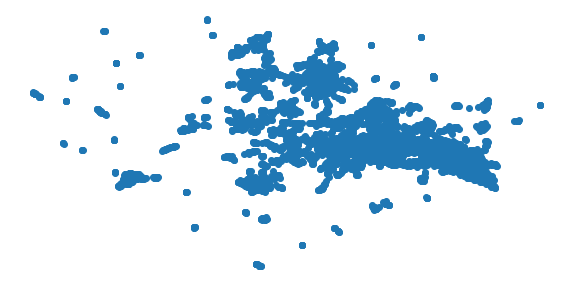

Number of neighbors: 8


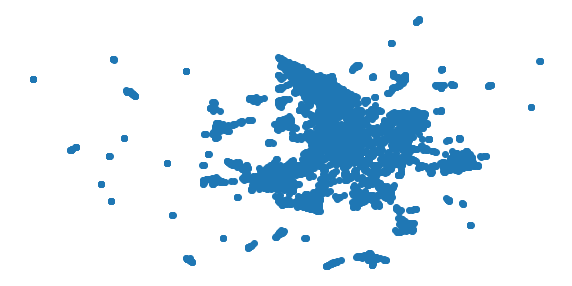

Number of neighbors: 9


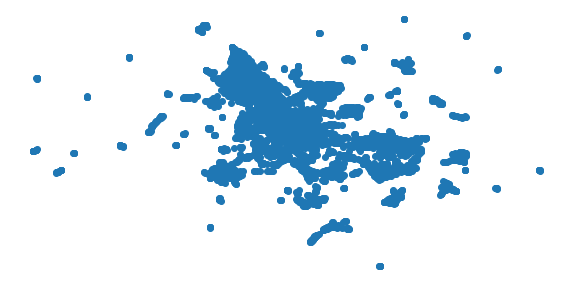

Number of neighbors: 10


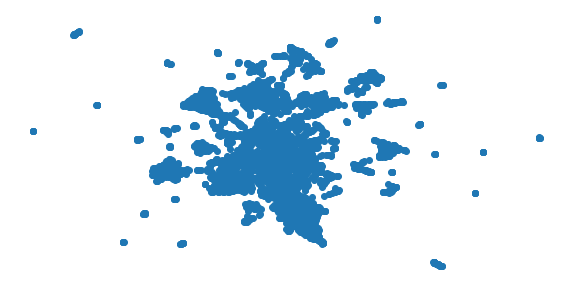

Number of neighbors: 11


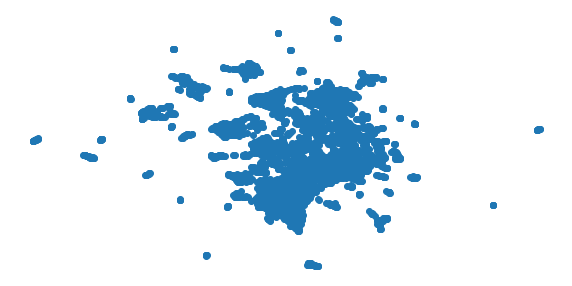

Number of neighbors: 12


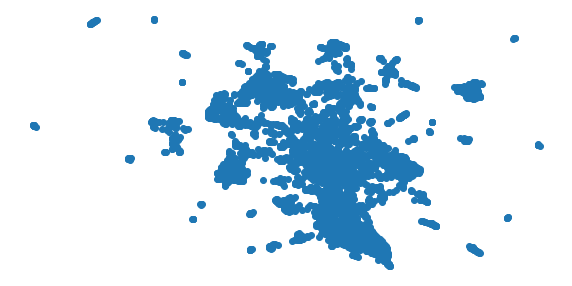

Number of neighbors: 13


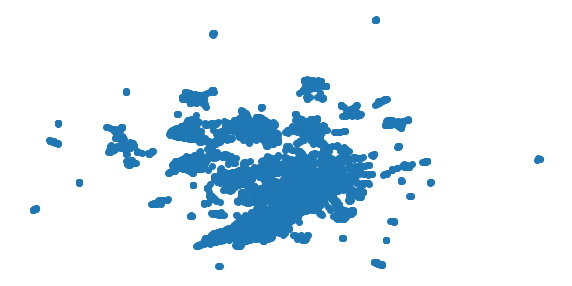

Number of neighbors: 14


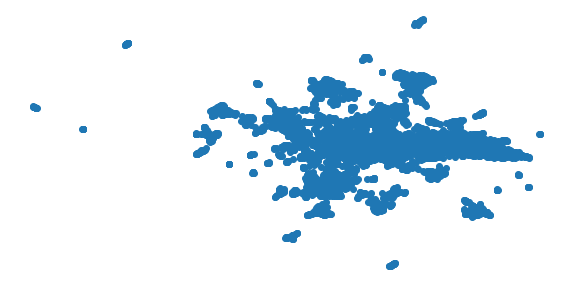

Number of neighbors: 15


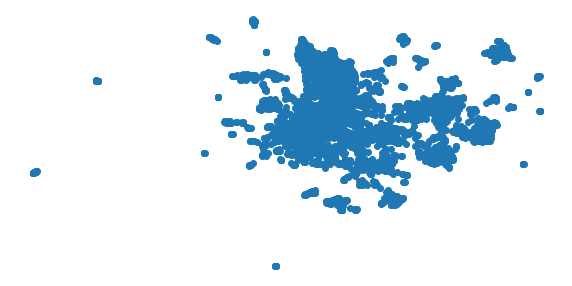

Number of neighbors: 16


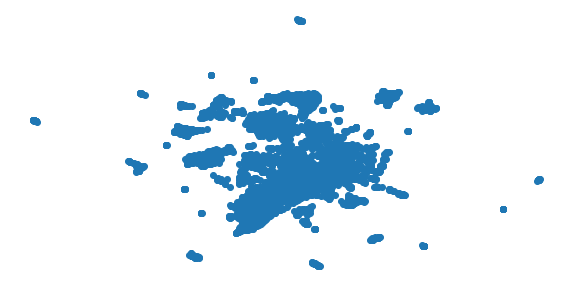

Number of neighbors: 17


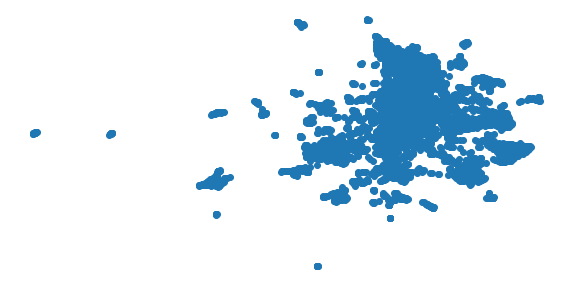

Number of neighbors: 18


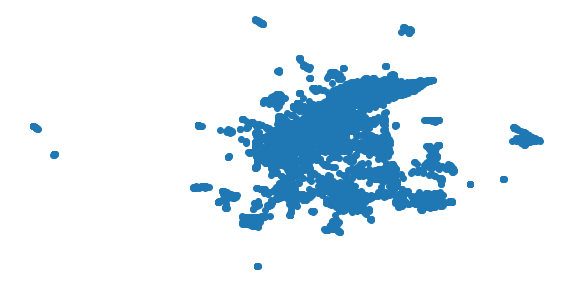

Number of neighbors: 19


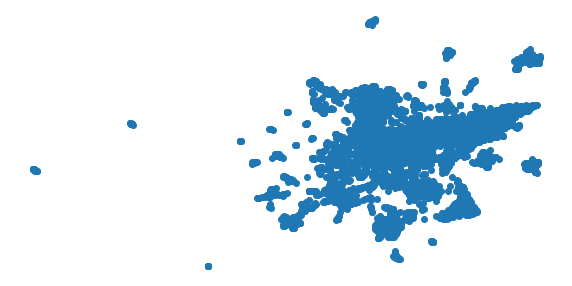

Number of neighbors: 20


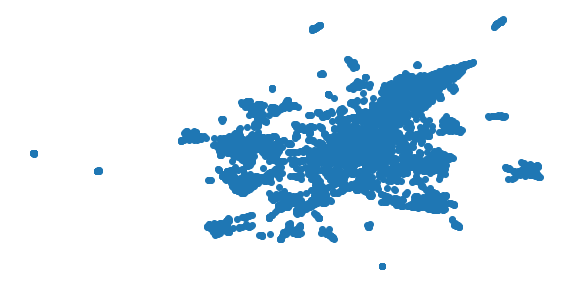

Min Dist: 0.4
Number of neighbors: 3


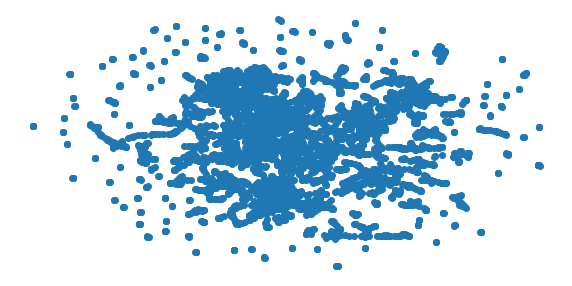

Number of neighbors: 4


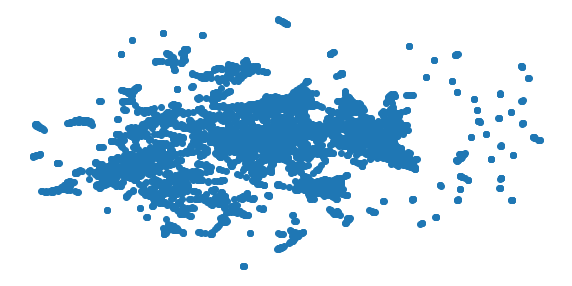

Number of neighbors: 5


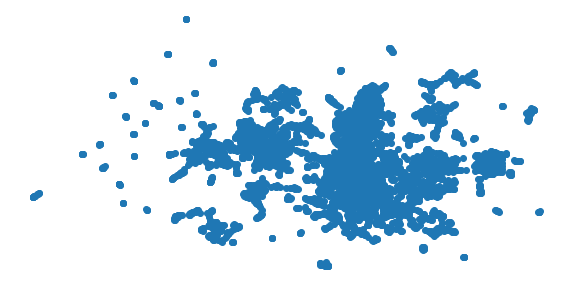

Number of neighbors: 6


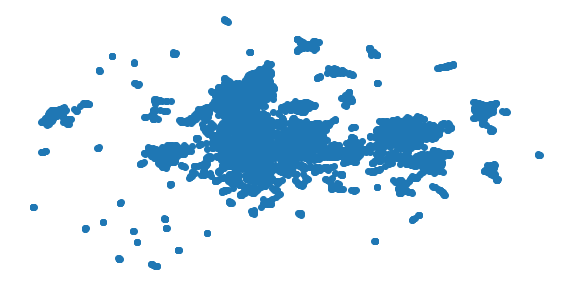

Number of neighbors: 7


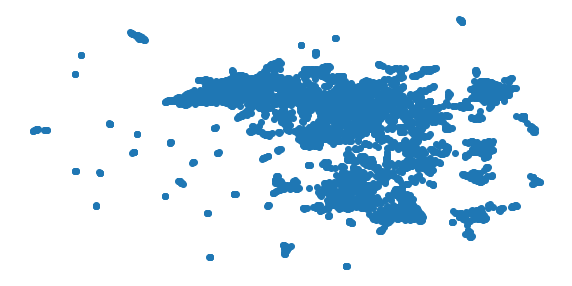

Number of neighbors: 8


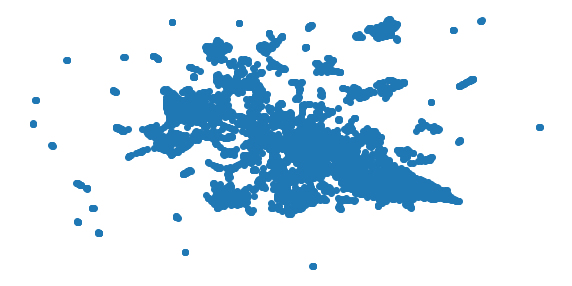

Number of neighbors: 9


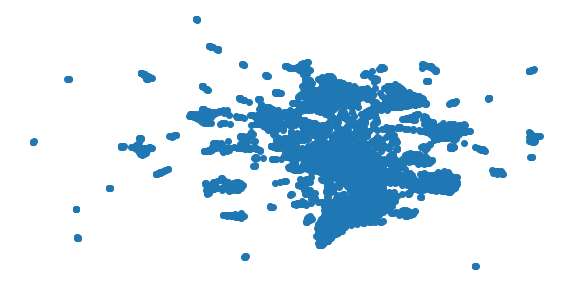

Number of neighbors: 10


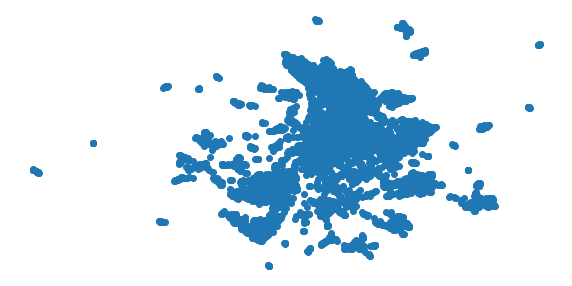

Number of neighbors: 11


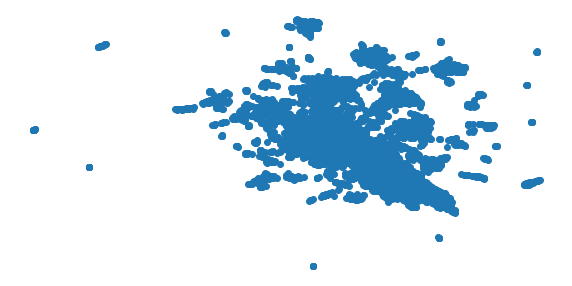

Number of neighbors: 12


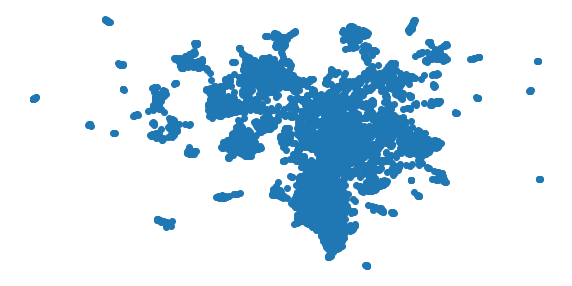

Number of neighbors: 13


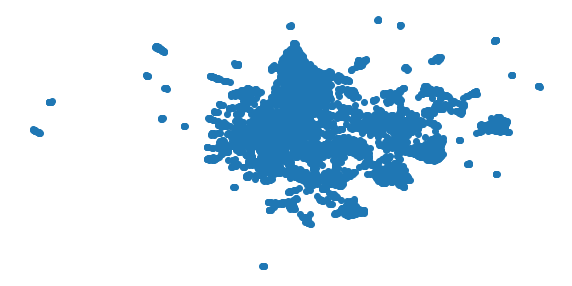

Number of neighbors: 14


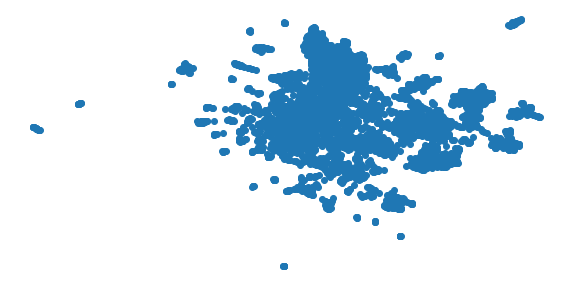

Number of neighbors: 15


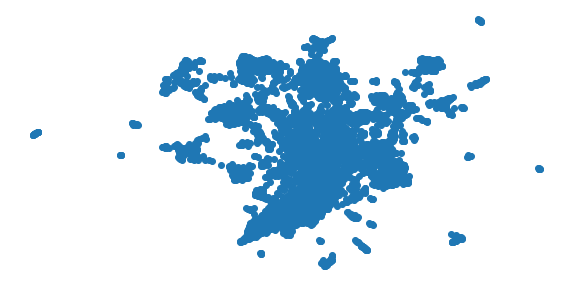

Number of neighbors: 16


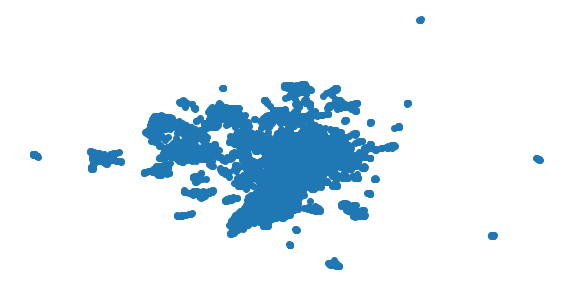

Number of neighbors: 17


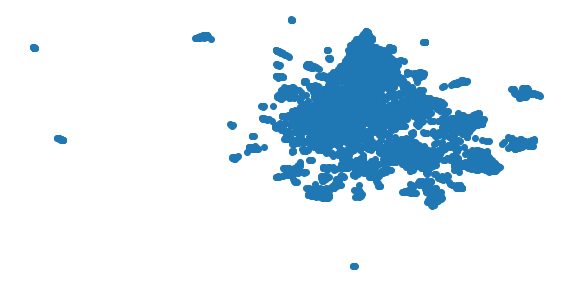

Number of neighbors: 18


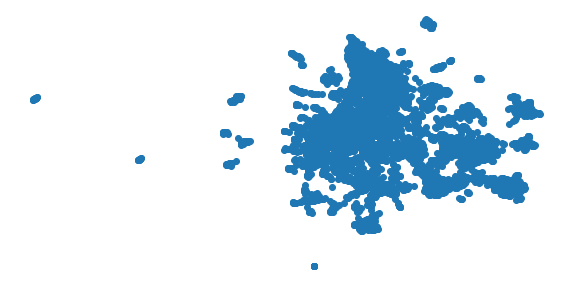

Number of neighbors: 19


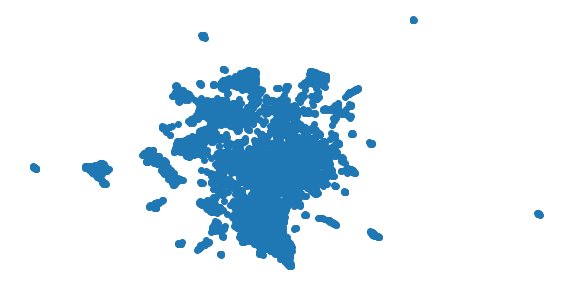

Number of neighbors: 20


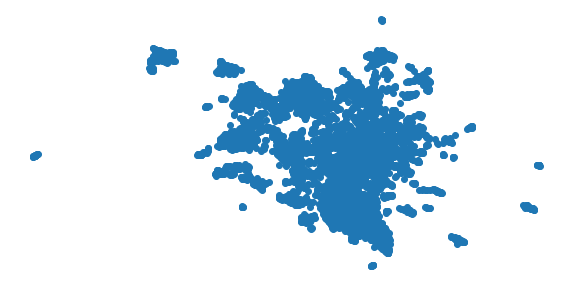

Min Dist: 0.5
Number of neighbors: 3


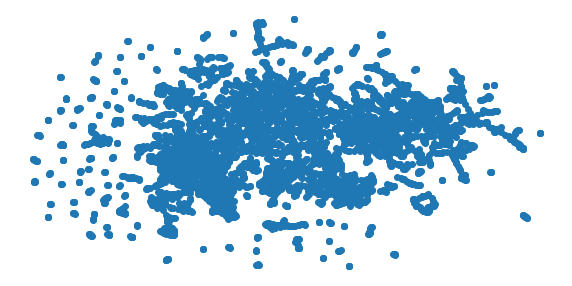

Number of neighbors: 4


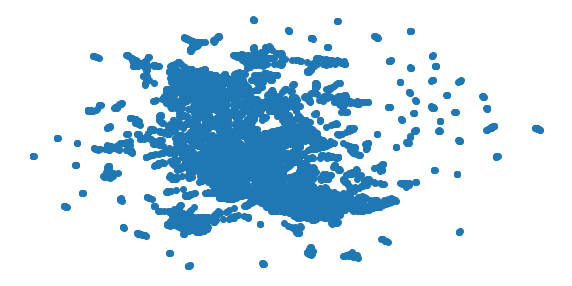

Number of neighbors: 5


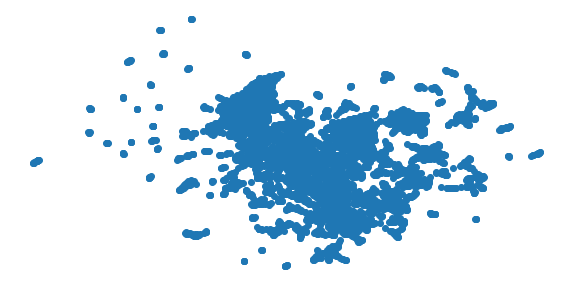

Number of neighbors: 6


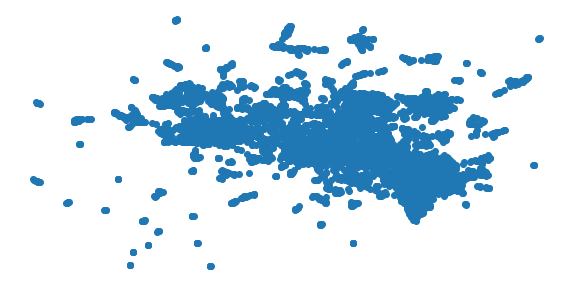

Number of neighbors: 7


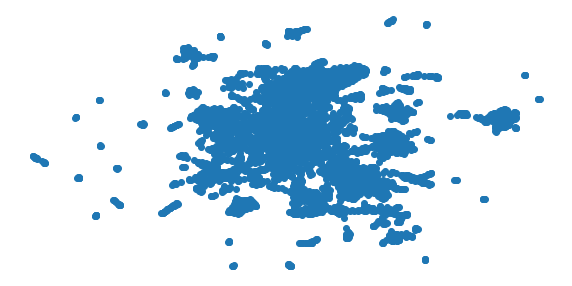

Number of neighbors: 8


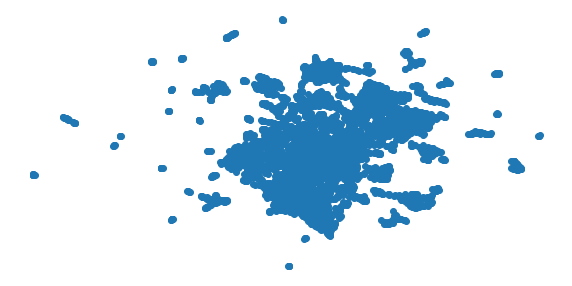

Number of neighbors: 9


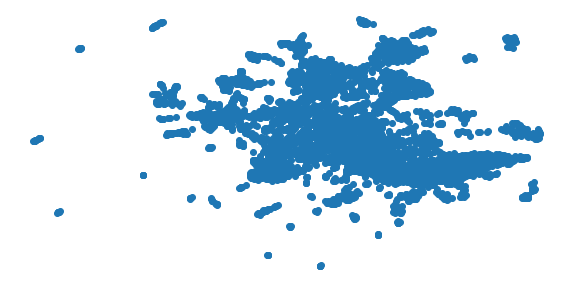

Number of neighbors: 10


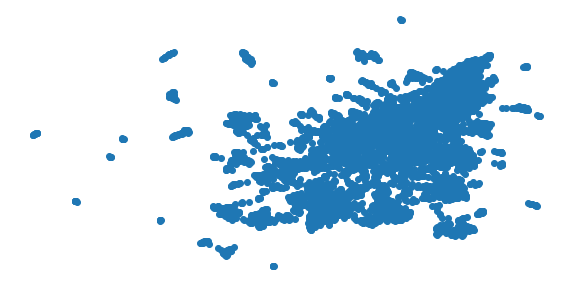

Number of neighbors: 11


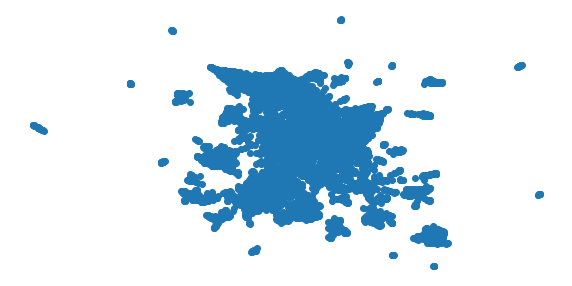

Number of neighbors: 12


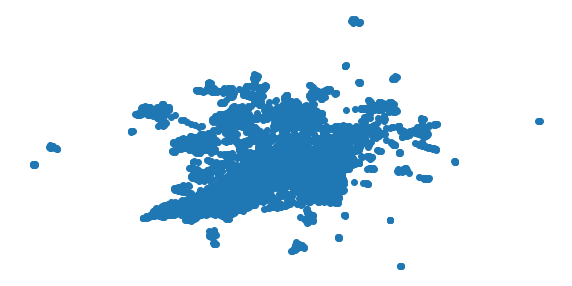

Number of neighbors: 13


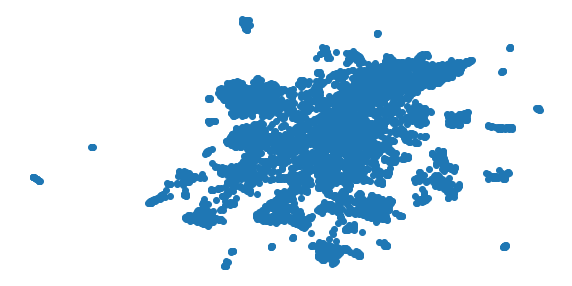

Number of neighbors: 14


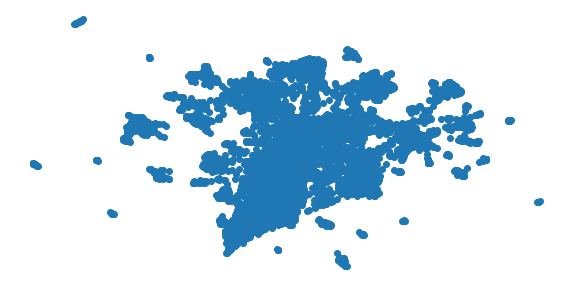

Number of neighbors: 15


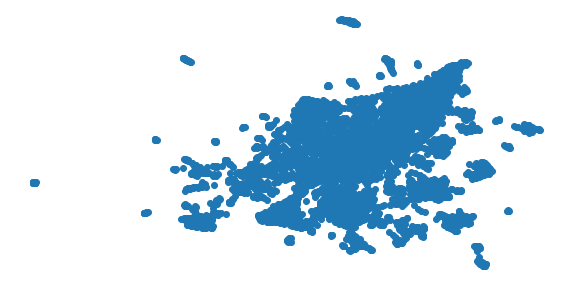

Number of neighbors: 16


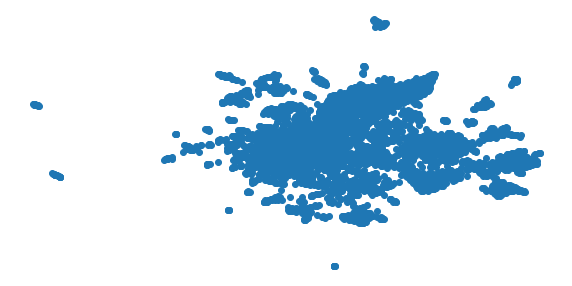

Number of neighbors: 17


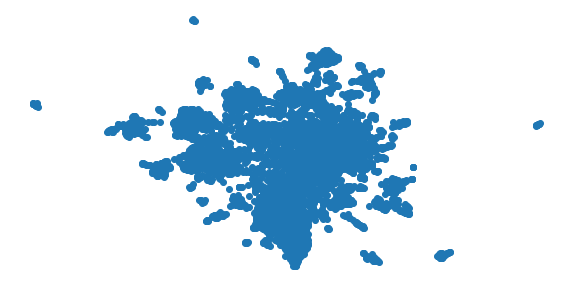

Number of neighbors: 18


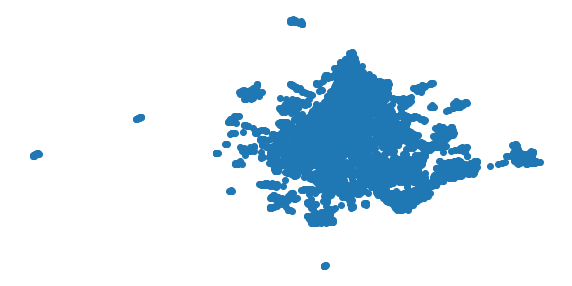

Number of neighbors: 19


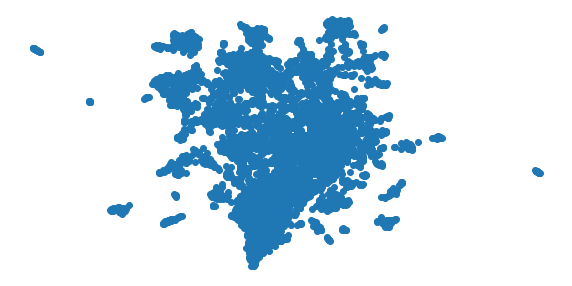

Number of neighbors: 20


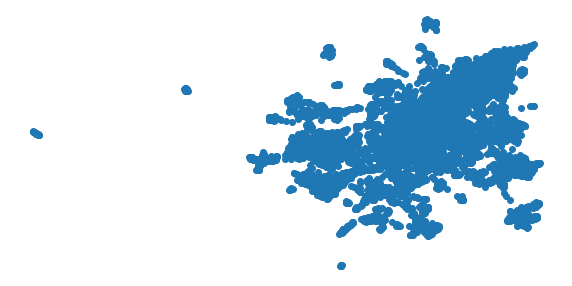

In [446]:
min_dists = [0.3, 0.4, 0.5]
neighbors = range(3, 21)

for min_dist in min_dists:
    
    print('Min Dist: {}'.format(str(min_dist)))

    for neighbor in neighbors:

        # Number of neighbors
        print('Number of neighbors: {}'.format(str(neighbor)))

        # Define UMAP
        umap_results = umap.UMAP(n_neighbors=neighbor,
                                 min_dist=min_dist,
                                 metric='correlation').fit_transform(X_pca)

        # Plot visual
        plt.figure(figsize=(10,5))
        plt.scatter(umap_results[:, 0], umap_results[:, 1])
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
        plt.show()